# Data Load 및 패키지 import


In [20]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from scipy import stats
import seaborn as sns


In [21]:
!apt-get update -qq
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

import matplotlib.font_manager as fm

# 폰트 설치 후 적용
plt.rc('font', family='NanumGothic')

# 한글 폰트 리스트 확인 (필요할 경우)
font_list = fm.findSystemFonts(fontpaths=None, fontext='ttf')
[font for font in font_list if 'Nanum' in font]

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 50 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped dire

['/usr/share/fonts/truetype/nanum/NanumSquareRoundR.ttf',
 '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf',
 '/usr/share/fonts/truetype/nanum/NanumGothic.ttf',
 '/usr/share/fonts/truetype/nanum/NanumSquareR.ttf',
 '/usr/share/fonts/truetype/nanum/NanumBarunGothicBold.ttf',
 '/usr/share/fonts/truetype/nanum/NanumMyeongjoBold.ttf',
 '/usr/share/fonts/truetype/nanum/NanumGothicBold.ttf',
 '/usr/share/fonts/truetype/nanum/NanumSquareRoundB.ttf',
 '/usr/share/fonts/truetype/nanum/NanumGothicCodingBold.ttf',
 '/usr/share/fonts/truetype/nanum/NanumGothicCoding.ttf',
 '/usr/share/fonts/truetype/nanum/NanumSquareB.ttf',
 '/usr/share/fonts/truetype/nanum/NanumMyeongjo.ttf']

In [22]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
climate_path = "/content/drive/MyDrive/CBA/dataset/climate/processed/station/"
wheat_production_path = "/content/drive/MyDrive/CBA/dataset/wheat_production/"
wheat_price_path = "/content/drive/MyDrive/CBA/dataset/wheat_price/"
wheat_company_path = "/content/drive/MyDrive/CBA/dataset/wheat_company/"
summary_path = "/content/drive/MyDrive/CBA/summary/"

In [24]:
import pandas as pd

# File paths
files = {
    "Wheat_Production": wheat_production_path+'Australia_state_wheat_production.csv',
    "WA_Climate":  climate_path+'Australia_WA_Geraldton_Airport.csv',
    "SA_Climate":  climate_path+'Australia_SA_Cleve_SA.csv',
    "VIC_Climate":  climate_path+'Australia_VIC_Mallee_Snowtown.csv',
    "NSW_Climate": climate_path+'Australia_NSW_Moree_Aero.csv',
    "Wheat_Price": wheat_price_path+'3_AUS_wheat_price.csv',
    "Daehan_Flour_Mills": wheat_company_path+'Daehan_Flour_Mills.csv'
}

# Try loading datasets with different encodings
datasets = {}
for name, path in files.items():
    try:
        datasets[name] = pd.read_csv(path, encoding='utf-8')
        print(f"{name} loaded with 'utf-8' encoding.")
    except UnicodeDecodeError:
        try:
            datasets[name] = pd.read_csv(path, encoding='euc-kr')
            print(f"{name} loaded with 'euc-kr' encoding.")
        except UnicodeDecodeError:
            print(f"Failed to load {name} with both 'utf-8' and 'euc-kr'.")

# Display heads of successfully loaded datasets
for name, df in datasets.items():
    print(f"\nDataset: {name}")
    print(df.head())
    print(df.info())


Wheat_Production loaded with 'utf-8' encoding.
WA_Climate loaded with 'utf-8' encoding.
SA_Climate loaded with 'utf-8' encoding.
VIC_Climate loaded with 'utf-8' encoding.
NSW_Climate loaded with 'utf-8' encoding.
Wheat_Price loaded with 'utf-8' encoding.
Daehan_Flour_Mills loaded with 'utf-8' encoding.

Dataset: Wheat_Production
  state 2016-17 (1k ton) 2017-18 (1k ton) 2018-19 (1k ton) 2019-20 (1k ton)  \
0   NSW            9,819            4,703            1,850            1,772   
1   VIC            4,665            3,682            2,277            3,714   
2    SA            6,133            4,052            3,025            2,689   
3    WA            9,645            7,699            9,979            5,842   

  2020-21 (1k ton) 2021-22 (1k ton)  
0           12,972           12,029  
1            4,525            4,246  
2            3,982            4,750  
3            8,793           12,919  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (t

# 기후 + 생산량 데이터 분석


In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import numpy as np

# Preprocess wheat production data
wheat_production = datasets["Wheat_Production"].copy()
wheat_production.iloc[:, 1:] = wheat_production.iloc[:, 1:].replace(",", "", regex=True).astype(float)

# Merge climate data for each state with wheat production
climate_data = {
    "WA": datasets["WA_Climate"],
    "SA": datasets["SA_Climate"],
    "VIC": datasets["VIC_Climate"],
    "NSW": datasets["NSW_Climate"]
}

merged_data = {}
for state, climate_df in climate_data.items():
    # Replace -99.9 with NaN
    climate_df.replace(-99.9, np.nan, inplace=True)

    # Convert time to year for merging
    climate_df["Year"] = pd.to_datetime(climate_df["시각 (YYYY-MM-DD)"]).dt.year

    # Preprocess wheat production data for the state
    production_data = wheat_production[wheat_production["state"] == state].melt(
        id_vars=["state"], var_name="Year", value_name="Production (1k ton)"
    )
    production_data["Year"] = production_data["Year"].str.extract(r"(\d{4})").astype(int)

    # Merge climate and wheat production data
    merged_data[state] = pd.merge(
        production_data,
        climate_df[["Year", "월평균 일 최고기온 (°C)", "월평균 일 최저기온 (°C)",
                    "월별 일 최고기온(°C)","월별 일 최저기온(°C)",  "월 총 강수량 (mm)" ,
                    "월평균 일 태양복사량 (MJ/m^2)"]].groupby("Year").mean().reset_index(),
        on="Year",
        how="inner"
    )

    # Display the first few rows of the merged data for verification
    print(f"Merged Data for {state}:")
    print(merged_data[state].head())


Merged Data for WA:
  state  Year Production (1k ton)  월평균 일 최고기온 (°C)  월평균 일 최저기온 (°C)  \
0    WA  2016              9645.0        25.666667        13.033333   
1    WA  2017              7699.0        27.091667        13.466667   
2    WA  2018              9979.0        26.300000        13.508333   
3    WA  2019              5842.0        27.366667        13.450000   
4    WA  2020              8793.0        27.108333        14.391667   

   월별 일 최고기온(°C)  월별 일 최저기온(°C)  월 총 강수량 (mm)  월평균 일 태양복사량 (MJ/m^2)  
0      34.325000       7.950000     38.433333             19.658333  
1      35.858333       7.608333     27.566667             19.825000  
2      34.333333       7.516667     24.716667             19.766667  
3      36.975000       7.600000     21.100000             20.741667  
4      36.308333       8.783333     25.683333             20.050000  
Merged Data for SA:
  state  Year Production (1k ton)  월평균 일 최고기온 (°C)  월평균 일 최저기온 (°C)  \
0    SA  2016              6133.0        2

In [26]:
merged_data['WA'].head()

,state,Year,Production (1k ton),월평균 일 최고기온 (°C),월평균 일 최저기온 (°C),월별 일 최고기온(°C),월별 일 최저기온(°C),월 총 강수량 (mm),월평균 일 태양복사량 (MJ/m^2)
0,WA,2016,9645.0,25.666667,13.033333,34.325000,7.950000,38.433333,19.658333
1,WA,2017,7699.0,27.091667,13.466667,35.858333,7.608333,27.566667,19.825000
2,WA,2018,9979.0,26.300000,13.508333,34.333333,7.516667,24.716667,19.766667
3,WA,2019,5842.0,27.366667,13.450000,36.975000,7.600000,21.100000,20.741667
4,WA,2020,8793.0,27.108333,14.391667,36.308333,8.783333,25.683333,20.050000


In [27]:
all_data = pd.concat(merged_data.values(), keys=merged_data.keys()).reset_index(level=0).rename(columns={'level_0': 'State'})
all_data.head()

,State,state,Year,Production (1k ton),월평균 일 최고기온 (°C),월평균 일 최저기온 (°C),월별 일 최고기온(°C),월별 일 최저기온(°C),월 총 강수량 (mm),월평균 일 태양복사량 (MJ/m^2)
0,WA,WA,2016,9645.0,25.666667,13.033333,34.325000,7.950000,38.433333,19.658333
1,WA,WA,2017,7699.0,27.091667,13.466667,35.858333,7.608333,27.566667,19.825000
2,WA,WA,2018,9979.0,26.300000,13.508333,34.333333,7.516667,24.716667,19.766667
3,WA,WA,2019,5842.0,27.366667,13.450000,36.975000,7.600000,21.100000,20.741667
4,WA,WA,2020,8793.0,27.108333,14.391667,36.308333,8.783333,25.683333,20.050000


In [28]:
all_data.drop(columns=['State'], inplace=True)

In [29]:
print(all_data)

  state  Year Production (1k ton)  월평균 일 최고기온 (°C)  월평균 일 최저기온 (°C)  \
0    WA  2016              9645.0        25.666667        13.033333   
1    WA  2017              7699.0        27.091667        13.466667   
2    WA  2018              9979.0        26.300000        13.508333   
3    WA  2019              5842.0        27.366667        13.450000   
4    WA  2020              8793.0        27.108333        14.391667   
5    WA  2021             12919.0        27.083333        14.091667   
0    SA  2016              6133.0        22.058333        11.766667   
1    SA  2017              4052.0        22.875000        12.108333   
2    SA  2018              3025.0        22.933333        12.291667   
3    SA  2019              2689.0        23.391667        11.991667   
4    SA  2020              3982.0        22.116667        11.350000   
5    SA  2021              4750.0        21.883333        11.816667   
0   VIC  2016              4665.0        23.641667         9.266667   
1   VI

## 밀 생산량 - 기후 데이터 correlation heatmap

/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


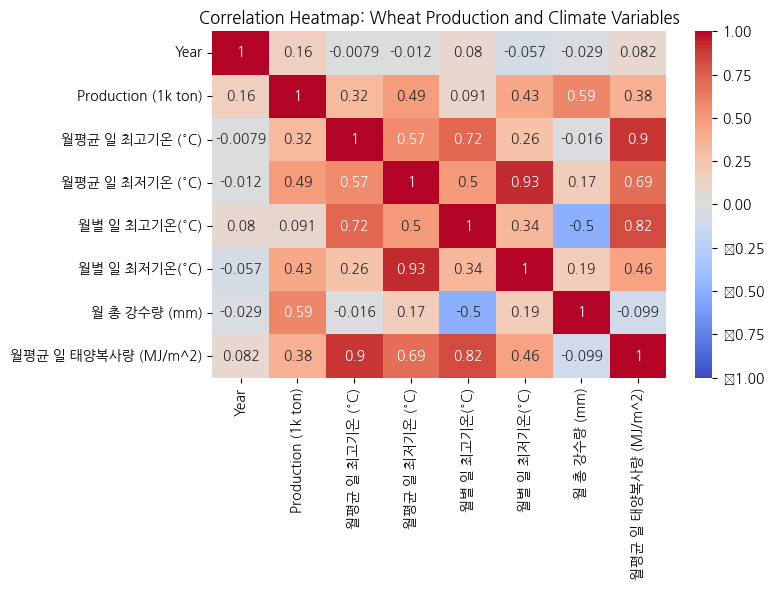

In [30]:
# Heatmap of correlation
plt.figure(figsize=(8, 6))
except_state_data = all_data.drop(columns=["state"])
correlation_matrix = except_state_data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Heatmap: Wheat Production and Climate Variables")
plt.tight_layout()
plt.show()



In [31]:
# production와 같이 분석할 기후 데이터
x_labels = ["월평균 일 최고기온 (°C)" , "월평균 일 최저기온 (°C)" ,"월별 일 최고기온(°C)", "월별 일 최저기온(°C)", "월 총 강수량 (mm)", "월평균 일 태양복사량 (MJ/m^2)"]
y_label = "Production (1k ton)"

## 최고 온도 vs 밀 생산량 scatter plot

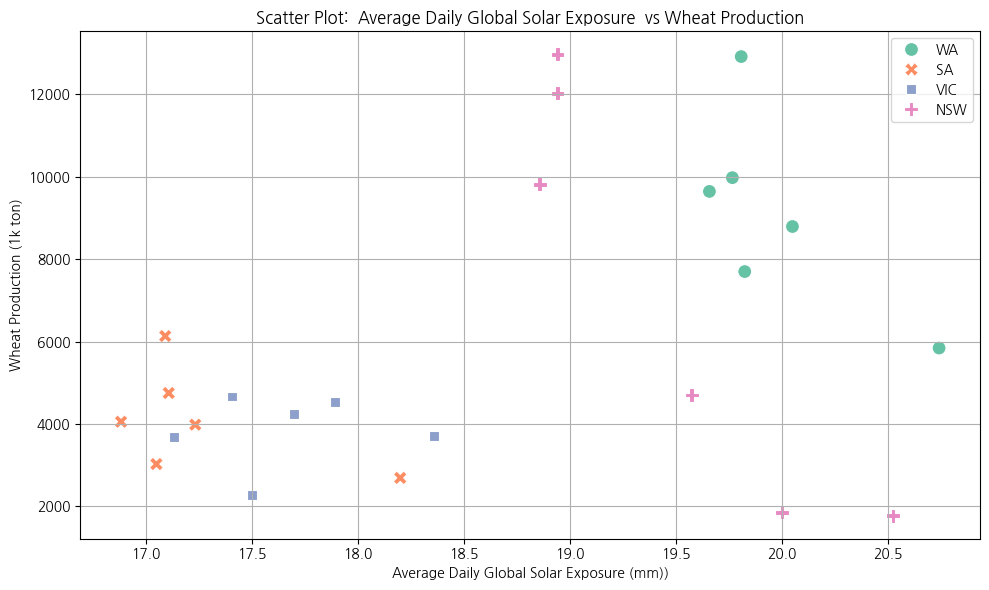

In [32]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=all_data,
    x="월평균 일 태양복사량 (MJ/m^2)",
    y="Production (1k ton)",
    hue="state",
    style="state",
    palette="Set2",
    s=100
)
plt.title("Scatter Plot:  Average Daily Global Solar Exposure  vs Wheat Production")
plt.xlabel("Average Daily Global Solar Exposure (mm))")
plt.ylabel("Wheat Production (1k ton)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## 생산량, 기후데이터(평균최고온도, 강수량) time series plot

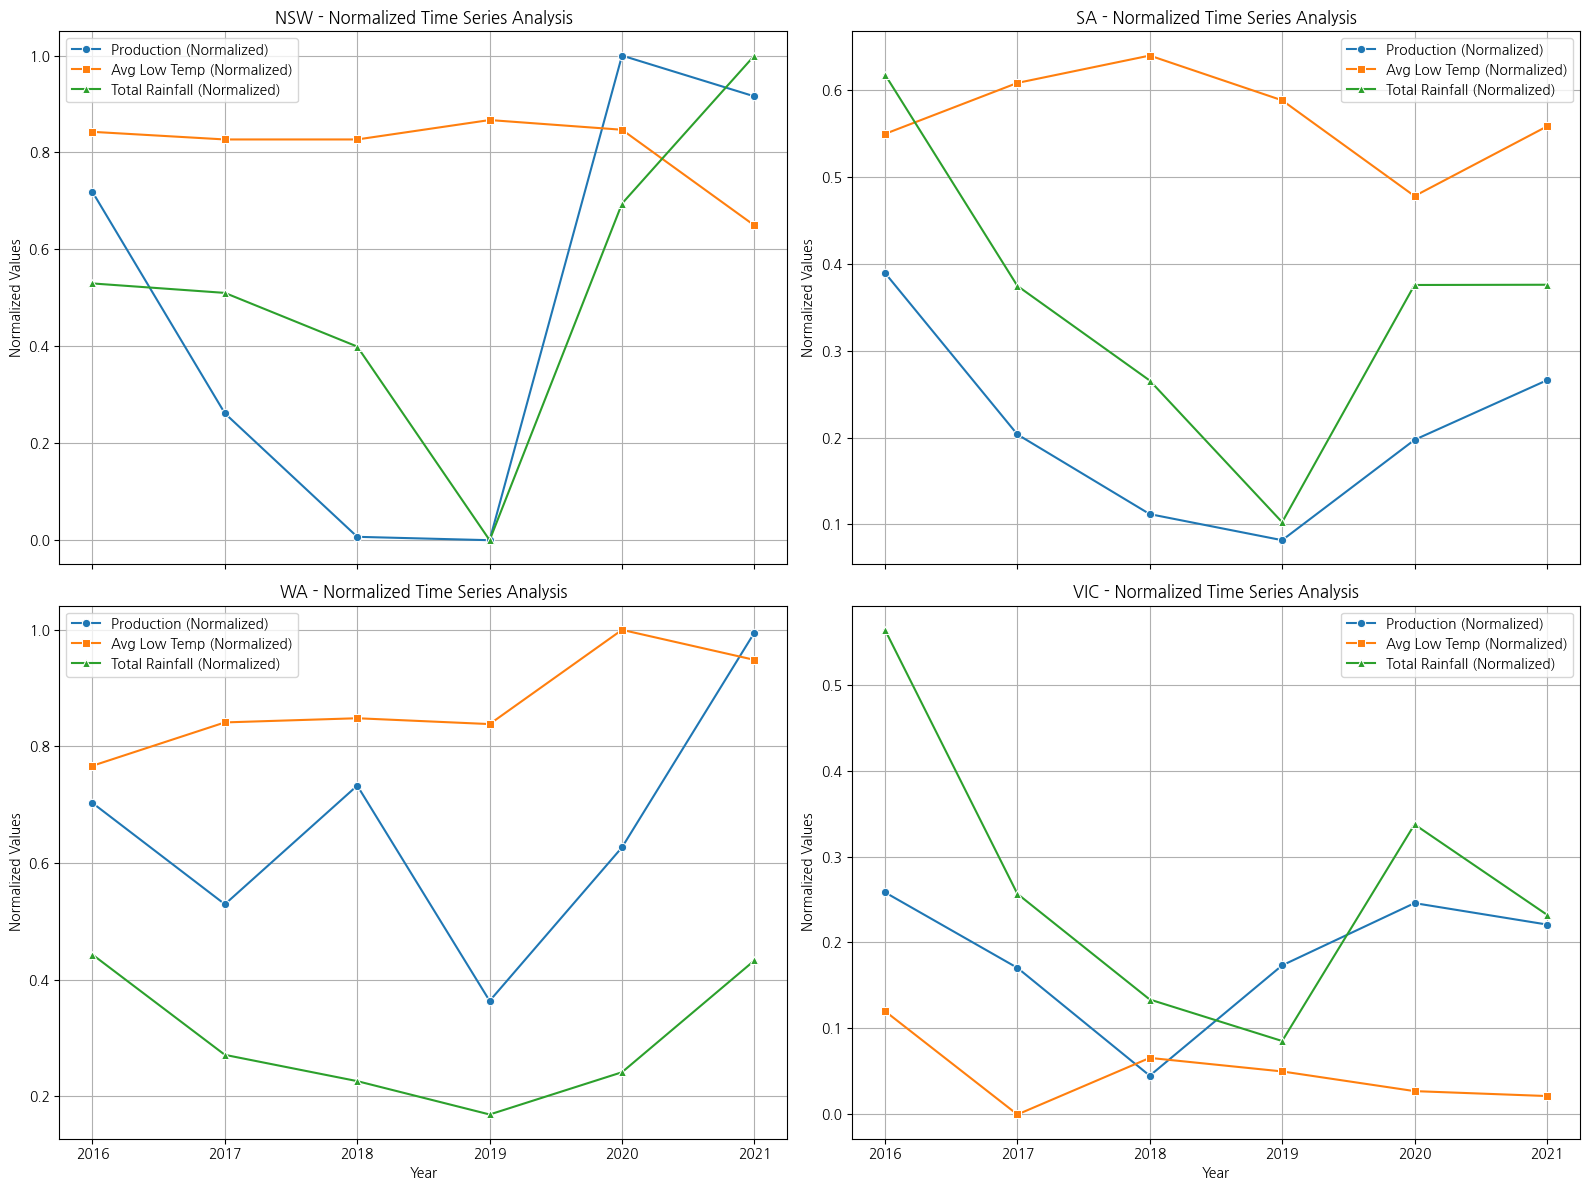

In [33]:
from sklearn.preprocessing import MinMaxScaler

# states
states=['NSW', 'SA', 'WA', 'VIC']

# Normalize Production and Climate variables for visualization
scaler = MinMaxScaler()

# Select columns to normalize
columns_to_normalize = ["Production (1k ton)", "월평균 일 최저기온 (°C)", "월 총 강수량 (mm)"]
all_data[columns_to_normalize] = scaler.fit_transform(all_data[columns_to_normalize])

# Plotting normalized data for each state
fig, axes = plt.subplots(2, 2, figsize=(16, 12), sharex=True)
axes = axes.flatten()

for i, state in enumerate(states):
    state_data = all_data[all_data["state"] == state]

    # Plot normalized Production
    sns.lineplot(
        data=state_data, x="Year", y="Production (1k ton)", label="Production (Normalized)", ax=axes[i], marker="o"
    )

    # Plot normalized Average High Temperature
    sns.lineplot(
        data=state_data, x="Year", y="월평균 일 최저기온 (°C)", label="Avg Low Temp (Normalized)", ax=axes[i], marker="s"
    )

    # Plot normalized Total Rainfall
    sns.lineplot(
        data=state_data, x="Year", y="월 총 강수량 (mm)", label="Total Rainfall (Normalized)", ax=axes[i], marker="^"
    )

    # Customize each subplot
    axes[i].set_title(f"{state} - Normalized Time Series Analysis")
    axes[i].set_ylabel("Normalized Values")
    axes[i].set_xlabel("Year")
    axes[i].grid(True)
    axes[i].legend()

plt.tight_layout()
plt.show()


## 회귀 모델

In [34]:
import statsmodels.api as sm

# Prepare the data for multiple linear regression
# Independent variables: 월평균 일 최고기온 (°C), 월 총 강수량 (mm)
# Dependent variable: Production (1k ton)
X = all_data[x_labels]
y = all_data["Production (1k ton)"]

# Add a constant to the model (intercept)
X = sm.add_constant(X)

# Fit the multiple linear regression model
model = sm.OLS(y, X).fit()


In [35]:
# Print the summary of the regression model
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     Production (1k ton)   R-squared:                       0.608
Model:                             OLS   Adj. R-squared:                  0.470
Method:                  Least Squares   F-statistic:                     4.396
Date:                 Sat, 07 Dec 2024   Prob (F-statistic):            0.00735
Time:                         04:04:08   Log-Likelihood:                 5.4898
No. Observations:                   24   AIC:                             3.020
Df Residuals:                       17   BIC:                             11.27
Df Model:                            6                                         
Covariance Type:             nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -2.1926      1.855     -1.182      0.254      -6.107       1.721
월평균 일 최고기온 (°C)         -0.1097      0.080     -1.377      0.187      -0.278       0.058
월평균 일 최저기온 (°C)          0.9882      0.941      1.050      0.309      -0.998       2.974
월별 일 최고기온(°C)            0.0903      0.084      1.076      0.297      -0.087       0.267
월별 일 최저기온(°C)           -0.1216      0.124     -0.984      0.339      -0.382       0.139
월 총 강수량 (mm)             1.1820      0.360      3.287      0.004       0.423       1.941
월평균 일 태양복사량 (MJ/m^2)     0.1098      0.122      0.902      0.380      -0.147       0.367
==============================================================================
Omnibus:                        0.141   Durbin-Watson:                   1.724
Prob(Omnibus):                  0.932   Jarque-Bera (JB):                0.361
Skew:                          -0.004   Prob(JB):                        0.835
Kurtosis:                       2.399   Cond. No.                     1.92e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.92e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## 전체 변수간의 scatter plot & KDE

/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


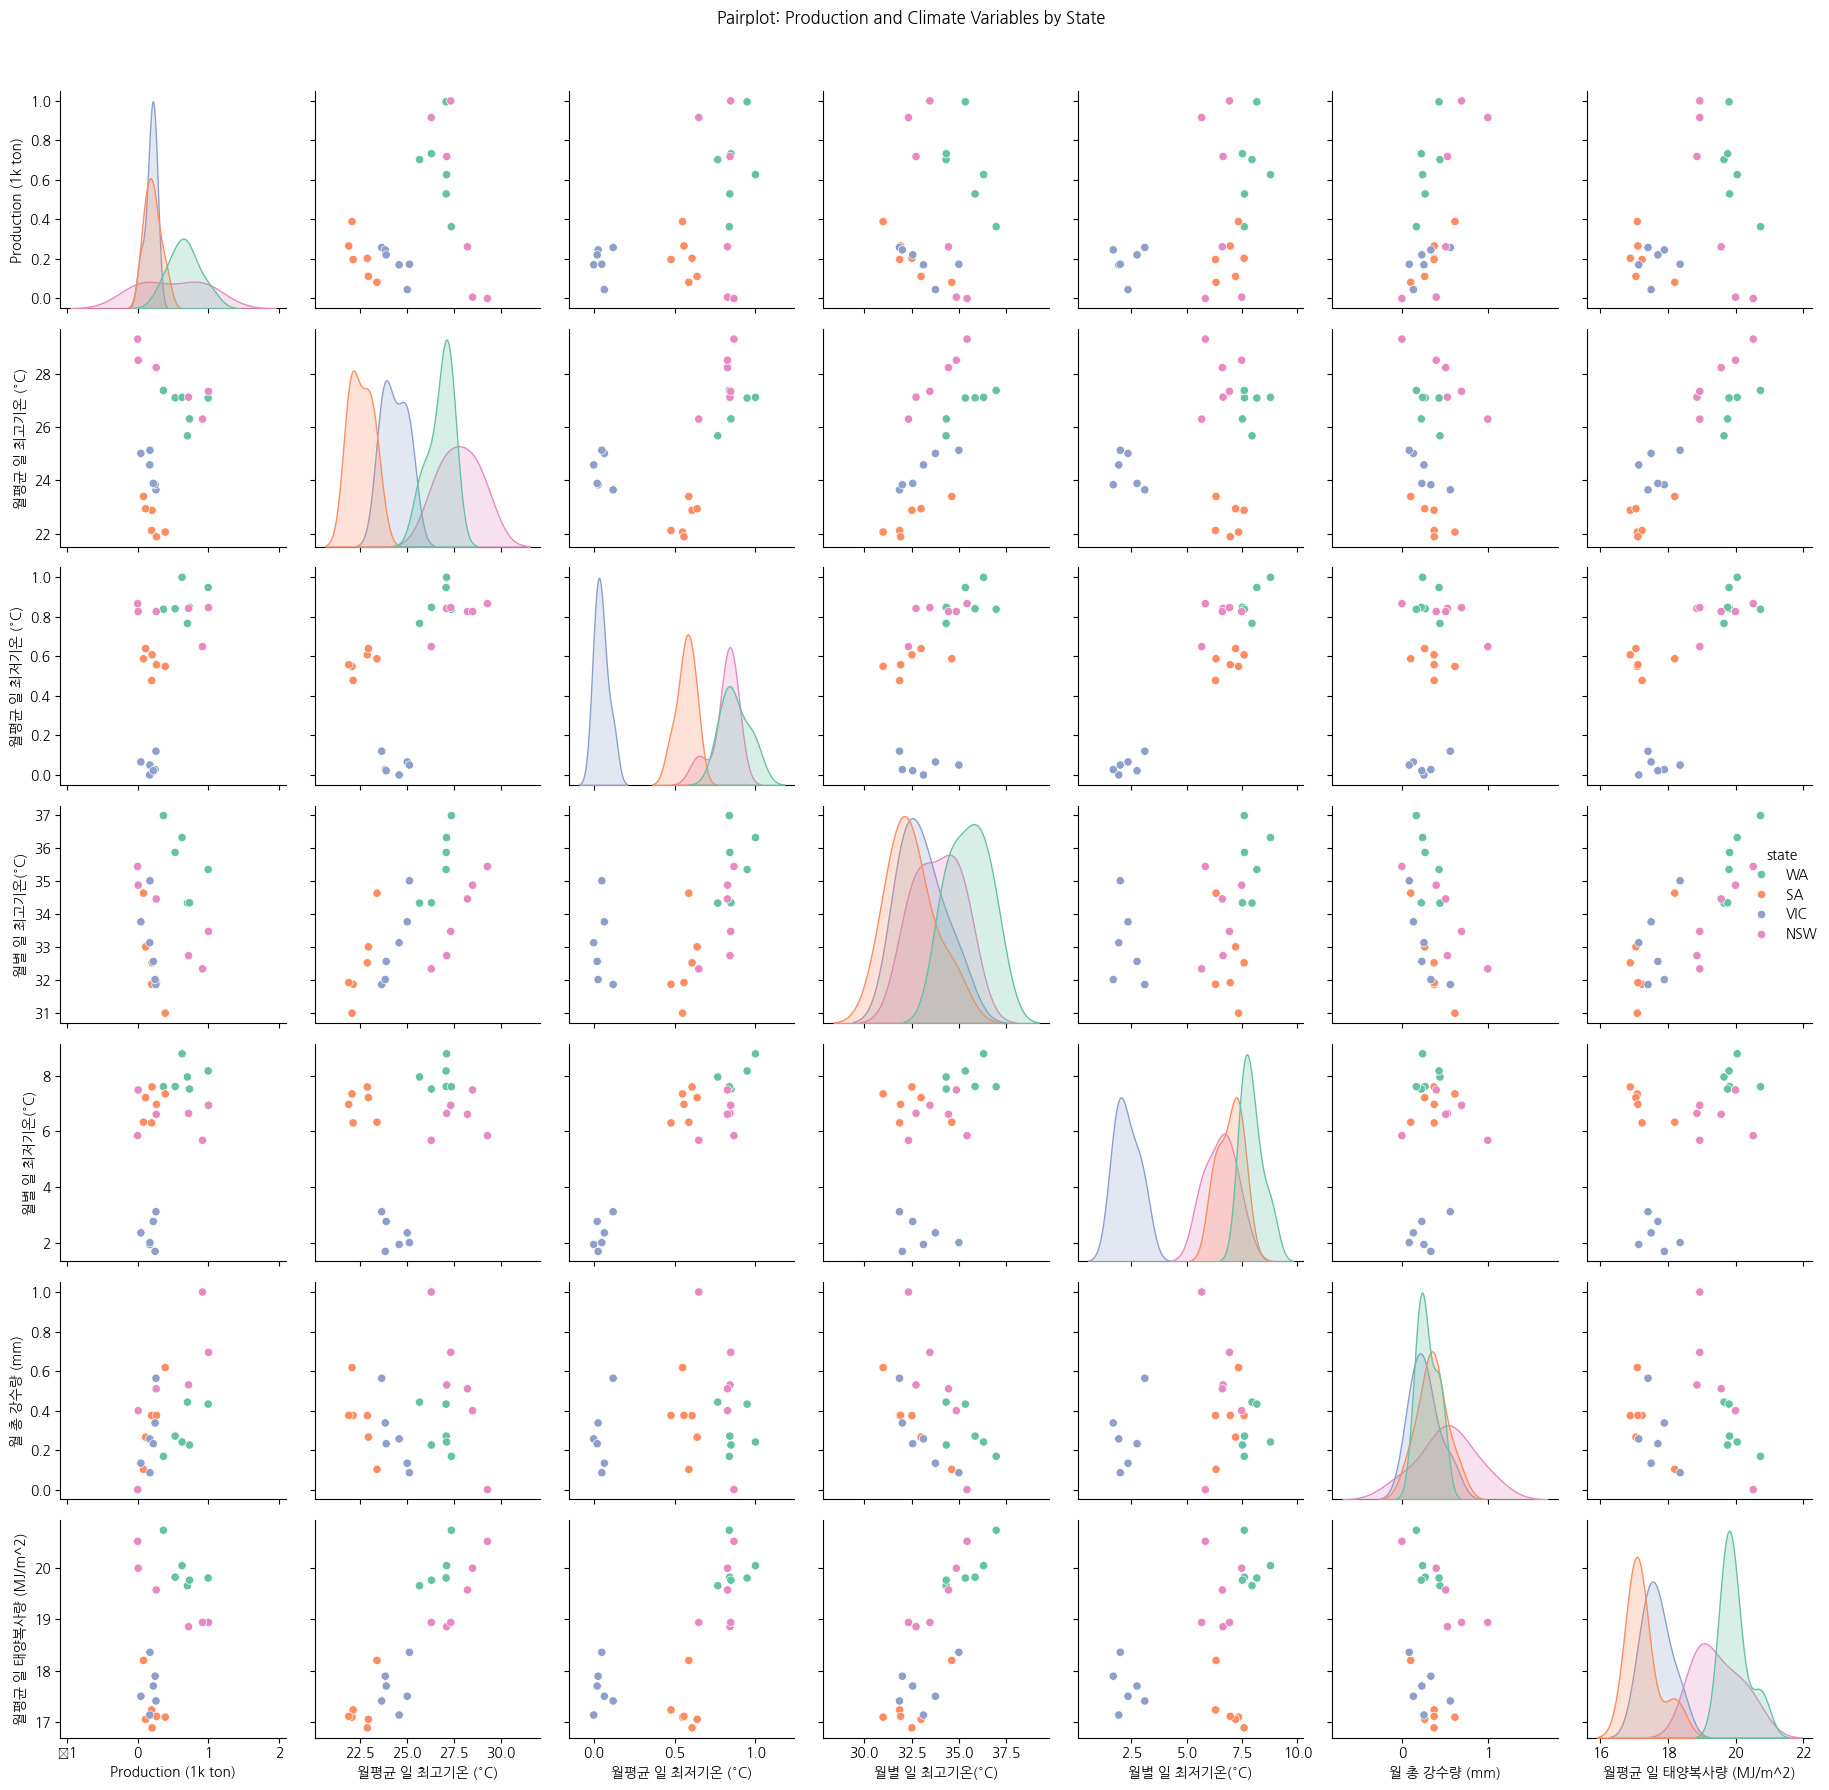

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select relevant columns for the pairplot
pairplot_data = all_data[["Production (1k ton)", "월평균 일 최고기온 (°C)" , "월평균 일 최저기온 (°C)" ,"월별 일 최고기온(°C)", "월별 일 최저기온(°C)", "월 총 강수량 (mm)", "월평균 일 태양복사량 (MJ/m^2)", "state"]]

# Create the pairplot
sns.pairplot(data=pairplot_data, hue="state", corner=False, diag_kind="kde", palette="Set2")
plt.suptitle("Pairplot: Production and Climate Variables by State", y=1.02)
plt.tight_layout()
plt.show()


## Regression plot

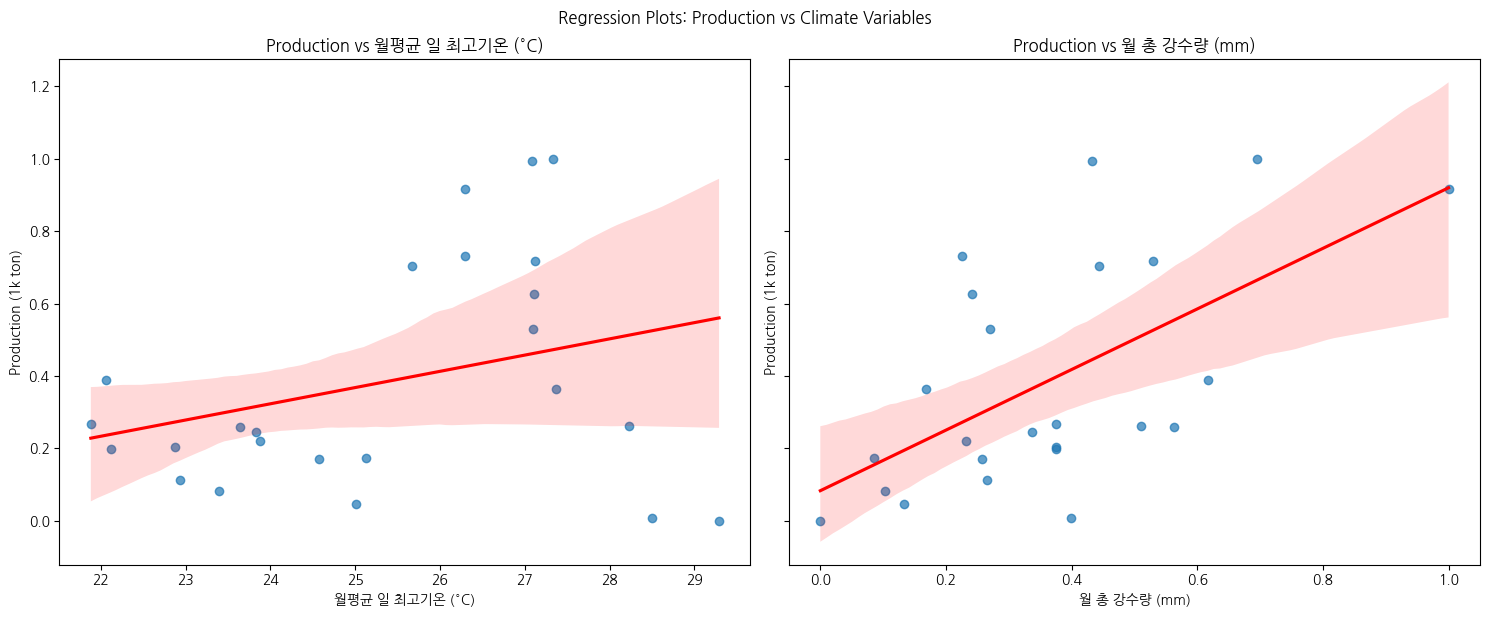

In [37]:
# pairplot_data = all_data[["Production (1k ton)", "월평균 일 최고기온 (°C)" , "월평균 일 최저기온 (°C)" ,"월별 일 최고기온(°C)", "월별 일 최저기온(°C)", "월 총 강수량 (mm)", "월평균 일 태양복사량 (MJ/m^2)", "state"]]


# Regression plots for each variable against Production (1k ton)
variables = ["월평균 일 최고기온 (°C)", "월 총 강수량 (mm)"]

# Create regression plots
fig, axes = plt.subplots(1, len(variables), figsize=(15, 6), sharey=True)

for i, var in enumerate(variables):
    sns.regplot(
        data=all_data,
        x=var,
        y="Production (1k ton)",
        ax=axes[i],
        scatter_kws={"alpha": 0.7},
        line_kws={"color": "red"},
    )
    axes[i].set_title(f"Production vs {var}")
    axes[i].set_xlabel(var)
    axes[i].set_ylabel("Production (1k ton)")

plt.tight_layout()
plt.suptitle("Regression Plots: Production vs Climate Variables", y=1.02)
plt.show()


In [38]:
all_data

,state,Year,Production (1k ton),월평균 일 최고기온 (°C),월평균 일 최저기온 (°C),월별 일 최고기온(°C),월별 일 최저기온(°C),월 총 강수량 (mm),월평균 일 태양복사량 (MJ/m^2)
0,WA,2016,0.702946,25.666667,0.766810,34.325000,7.950000,0.442774,19.658333
1,WA,2017,0.529196,27.091667,0.841202,35.858333,7.608333,0.270833,19.825000
2,WA,2018,0.732768,26.300000,0.848355,34.333333,7.516667,0.225738,19.766667
3,WA,2019,0.363393,27.366667,0.838340,36.975000,7.600000,0.168513,20.741667
4,WA,2020,0.626875,27.108333,1.000000,36.308333,8.783333,0.241034,20.050000
5,WA,2021,0.995268,27.083333,0.948498,35.341667,8.166667,0.432753,19.808333
0,SA,2016,0.389375,22.058333,0.549356,30.991667,7.341667,0.617616,17.091667
1,SA,2017,0.203571,22.875000,0.608011,32.516667,7.591667,0.374473,16.883333
2,SA,2018,0.111875,22.933333,0.639485,33.000000,7.208333,0.265559,17.050000
3,SA,2019,0.081875,23.391667,0.587983,34.625000,6.325000,0.102584,18.200000


            Variable 1       Variable 2  Correlation   P-Value
0  Production (1k ton)  월평균 일 최고기온 (°C)     0.316721  0.131578
1  Production (1k ton)     월 총 강수량 (mm)     0.591055  0.002354
2      월평균 일 최고기온 (°C)     월 총 강수량 (mm)    -0.016373  0.939471


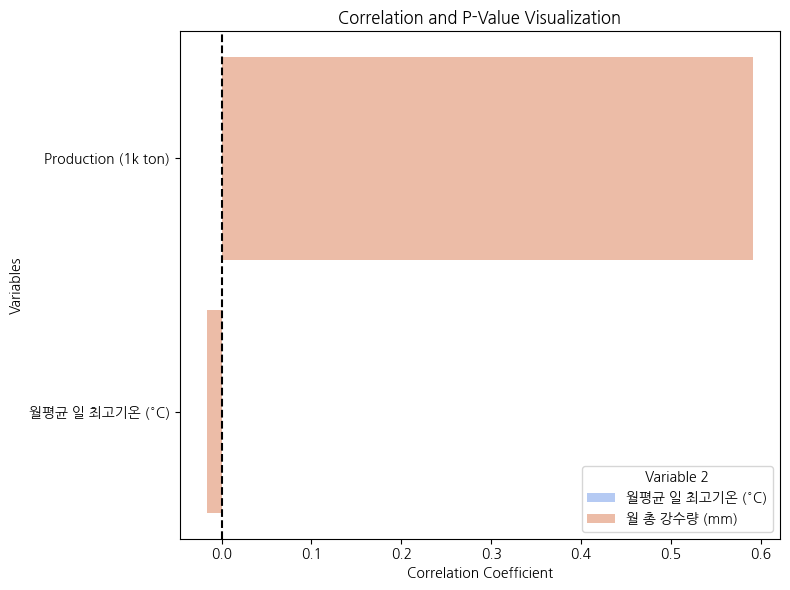

In [39]:
# p-value

from scipy.stats import pearsonr

# Extract variables for correlation and p-value calculation
variables = ["Production (1k ton)", "월평균 일 최고기온 (°C)", "월 총 강수량 (mm)"]
correlation_results = []

# Calculate correlation and p-value for each pair
for i in range(len(variables)):
    for j in range(i + 1, len(variables)):
        var1, var2 = variables[i], variables[j]
        corr, p_value = pearsonr(all_data[var1], all_data[var2])
        correlation_results.append({"Variable 1": var1, "Variable 2": var2, "Correlation": corr, "P-Value": p_value})

# Convert results to DataFrame for better visualization
correlation_df = pd.DataFrame(correlation_results)

# Print correlation and p-value results
print(correlation_df)

# Visualization of correlation results
plt.figure(figsize=(8, 6))
sns.barplot(
    data=correlation_df,
    x="Correlation",
    y="Variable 1",
    hue="Variable 2",
    palette="coolwarm",
    dodge=False
)
plt.axvline(x=0, color="black", linestyle="--")
plt.title("Correlation and P-Value Visualization")
plt.xlabel("Correlation Coefficient")
plt.ylabel("Variables")
plt.tight_layout()
plt.show()



# 기후 + 가격 데이터 분석

In [40]:
price_raw = datasets['Wheat_Price']
display(price_raw.head())
price_raw.info()

,DATE,구분,품목명,국가명,AGCODE,HSCODE,금액 (1k$),중량 (ton)
0,202410,수입,밀,오스트레일리아,111031123,1001190000,"24,650","10,000"
1,202410,수입,밀,오스트레일리아,111032001,1101001000,"31,436","24,148"
2,202410,수입,밀,오스트레일리아,111032042,1001991090,"90,000","200,000"
3,202410,수입,밀,오스트레일리아,111032052,1001992090,"29,186,447","84,970,080"
4,202410,수입,밀,오스트레일리아,111032062,1001999090,10,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 908 entries, 0 to 907
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   DATE      908 non-null    int64 
 1   구분        908 non-null    object
 2   품목명       908 non-null    object
 3   국가명       908 non-null    object
 4   AGCODE    908 non-null    int64 
 5   HSCODE    908 non-null    int64 
 6   금액 (1k$)  908 non-null    object
 7   중량 (ton)  908 non-null    object
dtypes: int64(3), object(5)
memory usage: 56.9+ KB


In [41]:
# 전처리
# Drop AGCODE
price_raw = price_raw.drop(columns=["AGCODE"])

# Convert "금액 (1k$)" and "중량 (ton)" to numeric, removing commas
price_raw["금액 (1k$)"] = price_raw["금액 (1k$)"].replace(",", "", regex=True).astype(float)
price_raw["중량 (ton)"] = price_raw["중량 (ton)"].replace(",", "", regex=True).astype(float)

# Group by DATE and sum other numeric columns
# price_processed = price_raw.groupby("DATE", as_index=False).sum()
# 2011-01 이후 데이터만 가져오기
price = price_raw[price_raw['DATE'] >=201101]

# Add a new column 'ton당 가격' to the price dataframe
price["톤당 가격(1k$/ton)"] = price["금액 (1k$)"] / price["중량 (ton)"]

# Assuming `price` is the dataframe
price["DATE"] = pd.to_datetime(price["DATE"], format="%Y%m").dt.strftime("%Y-%m-01")

# Display the processed DataFrame
# HS 코드는 무역 상품을 분류하기 위해 이름 및 숫자로 표기하는 국제 표준 체계
price.head()

<ipython-input-41-ac2302058e46>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price["톤당 가격(1k$/ton)"] = price["금액 (1k$)"] / price["중량 (ton)"]
<ipython-input-41-ac2302058e46>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price["DATE"] = pd.to_datetime(price["DATE"], format="%Y%m").dt.strftime("%Y-%m-01")


,DATE,구분,품목명,국가명,HSCODE,금액 (1k$),중량 (ton),톤당 가격(1k$/ton)
0,2024-10-01,수입,밀,오스트레일리아,1001190000,24650.0,10000.0,2.465000
1,2024-10-01,수입,밀,오스트레일리아,1101001000,31436.0,24148.0,1.301806
2,2024-10-01,수입,밀,오스트레일리아,1001991090,90000.0,200000.0,0.450000
3,2024-10-01,수입,밀,오스트레일리아,1001992090,29186447.0,84970080.0,0.343491
4,2024-10-01,수입,밀,오스트레일리아,1001999090,10.0,1.0,10.000000


In [42]:
price

,DATE,구분,품목명,국가명,HSCODE,금액 (1k$),중량 (ton),톤당 가격(1k$/ton)
0,2024-10-01,수입,밀,오스트레일리아,1001190000,24650.0,10000.0,2.465000
1,2024-10-01,수입,밀,오스트레일리아,1101001000,31436.0,24148.0,1.301806
2,2024-10-01,수입,밀,오스트레일리아,1001991090,90000.0,200000.0,0.450000
3,2024-10-01,수입,밀,오스트레일리아,1001992090,29186447.0,84970080.0,0.343491
4,2024-10-01,수입,밀,오스트레일리아,1001999090,10.0,1.0,10.000000
...,...,...,...,...,...,...,...,...
670,2011-05-01,수입,밀,오스트레일리아,1101001000,43049.0,30000.0,1.434967
671,2011-04-01,수입,밀,오스트레일리아,1101001000,19674.0,11280.0,1.744149
672,2011-03-01,수입,밀,오스트레일리아,1101001000,310.0,111.0,2.792793
673,2011-02-01,수입,밀,오스트레일리아,1101001000,65797.0,61222.0,1.074728


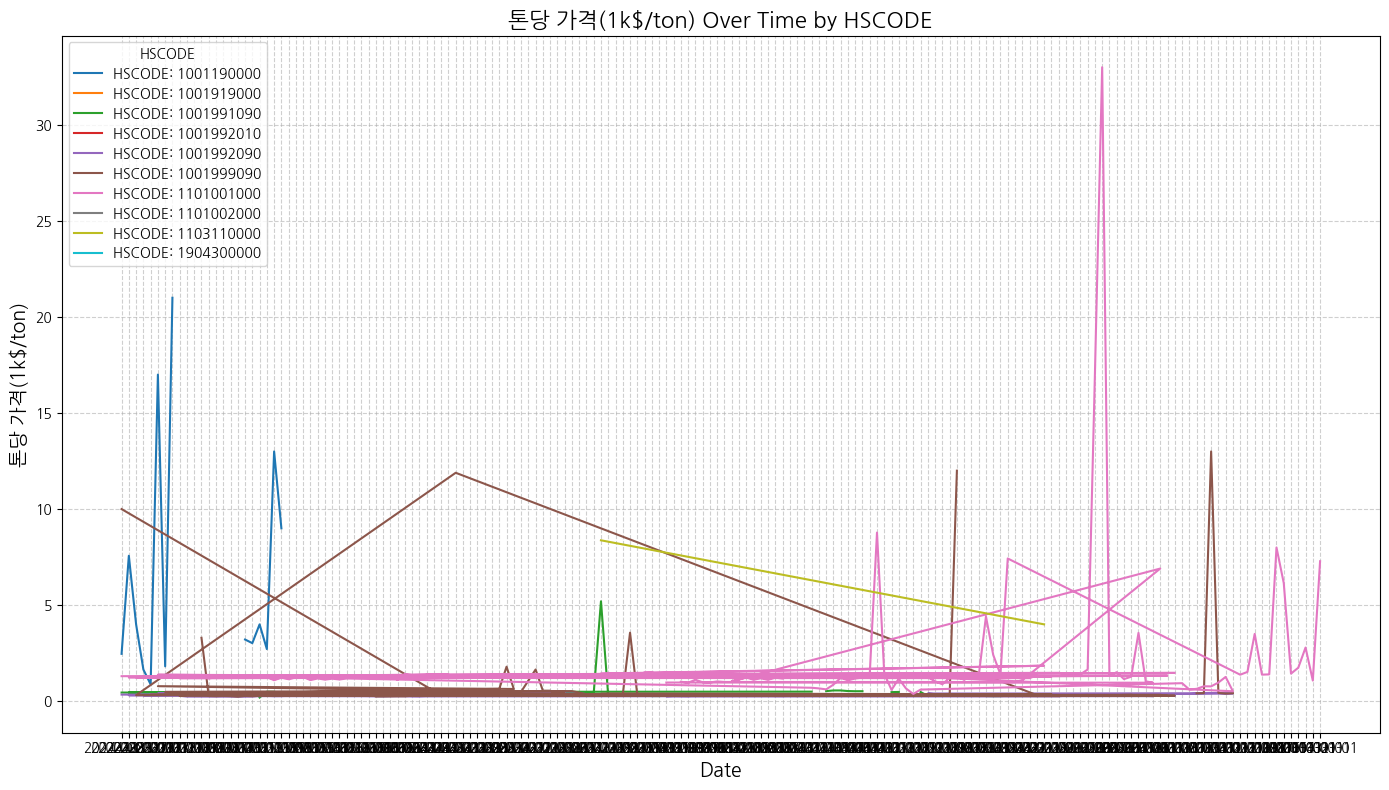

In [43]:
# Plot 톤당 가격 over time by HSCODE
plt.figure(figsize=(14, 8))

# Group data by HSCODE and plot each group
for hscode, group_data in price.groupby("HSCODE"):
    plt.plot(group_data["DATE"], group_data["톤당 가격(1k$/ton)"], label=f"HSCODE: {hscode}")

# Customize plot
plt.title("톤당 가격(1k$/ton) Over Time by HSCODE", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("톤당 가격(1k$/ton)", fontsize=14)
plt.legend(title="HSCODE", fontsize=10, loc="upper left")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()

# Show the plot
plt.show()

In [44]:
# Get unique HSCODE values
unique_hscodes = price["HSCODE"].unique()

# Display unique HSCODEs
print("Unique HSCODEs:")
print(unique_hscodes)


Unique HSCODEs:
[1001190000 1101001000 1001991090 1001992090 1001999090 1904300000
 1101002000 1103110000 1001992010 1001919000]


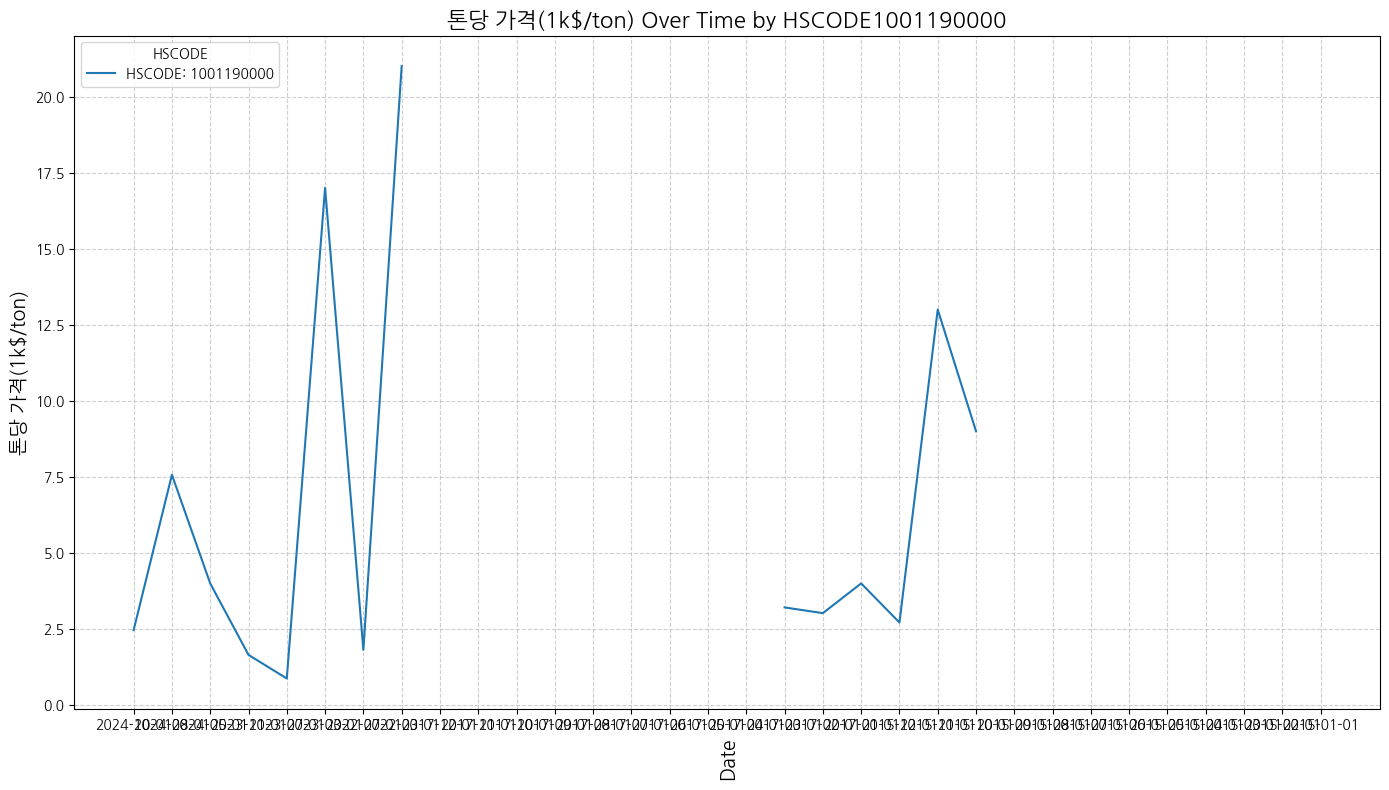

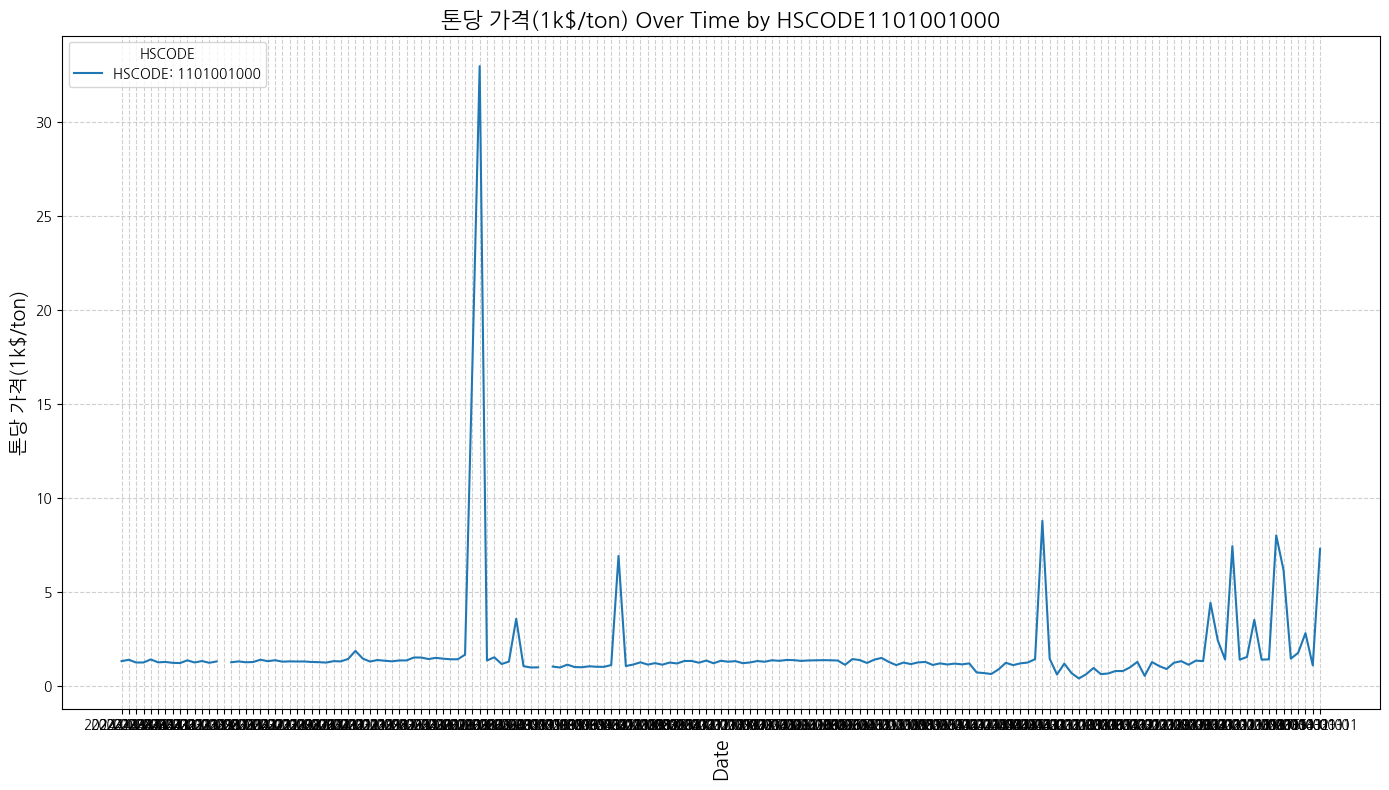

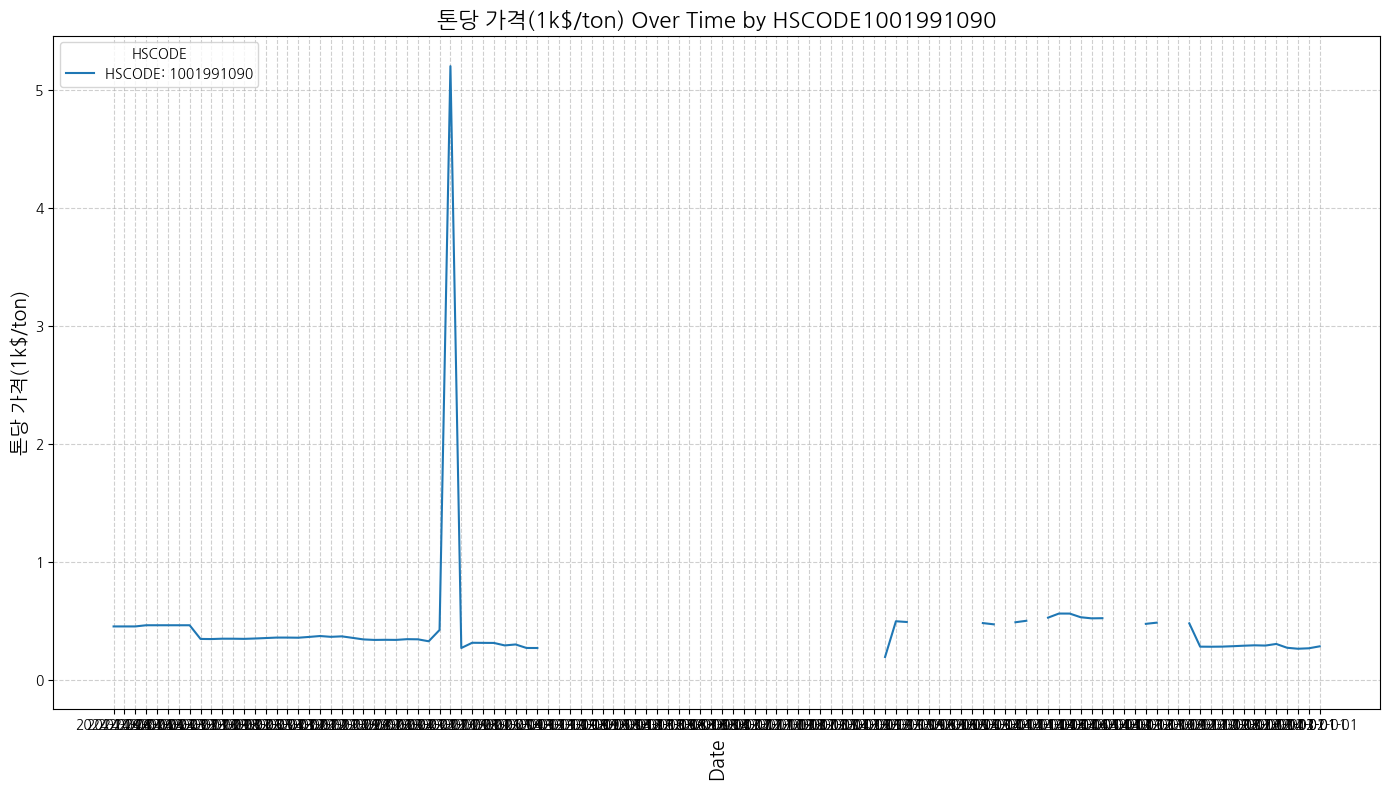

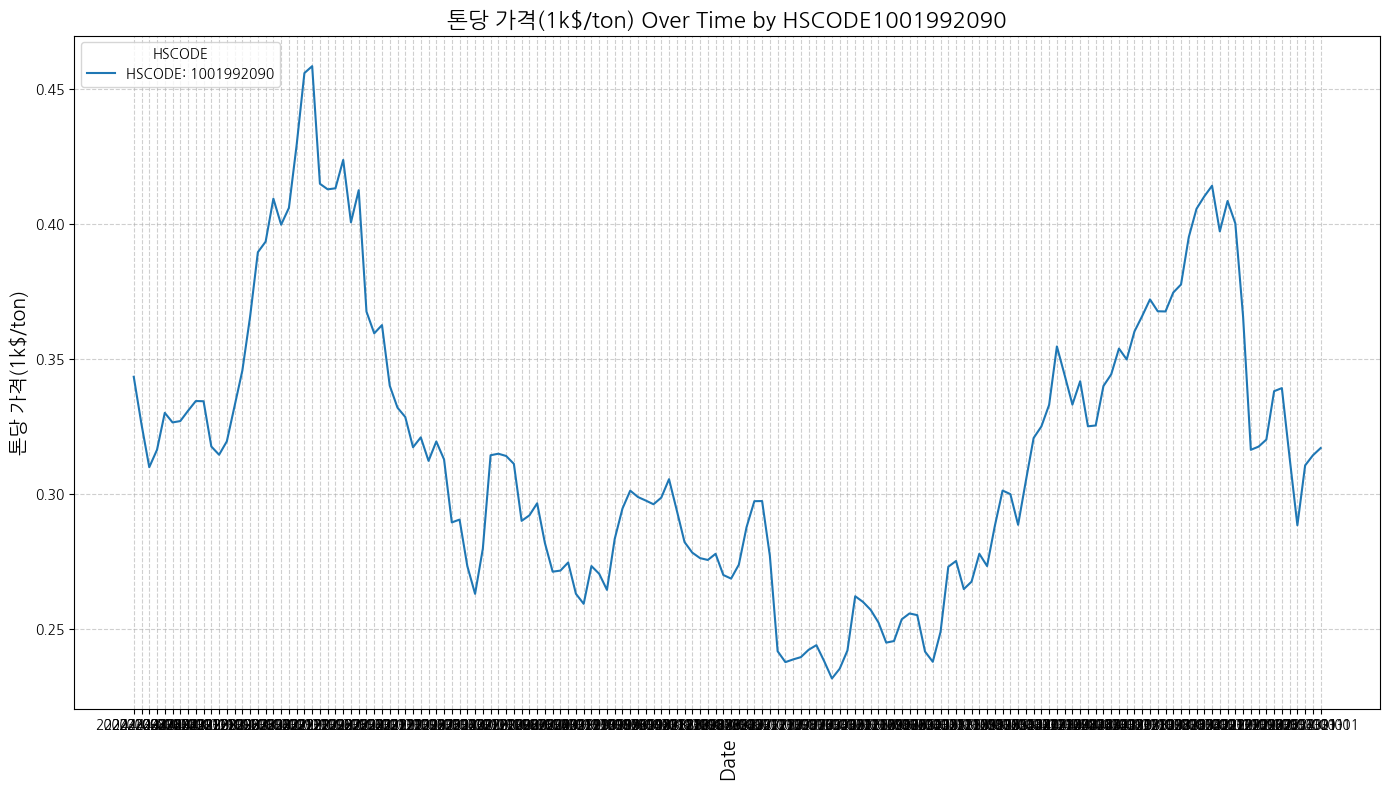

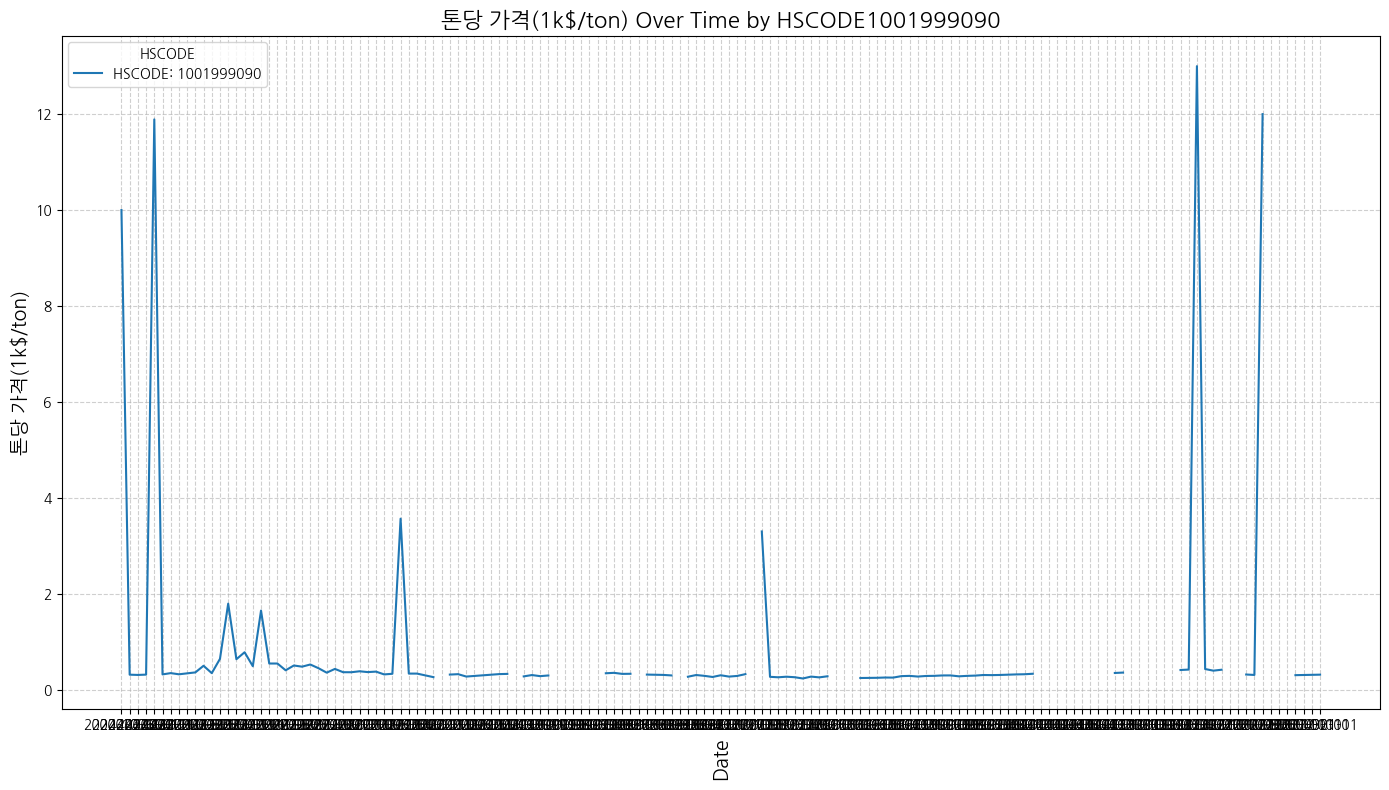

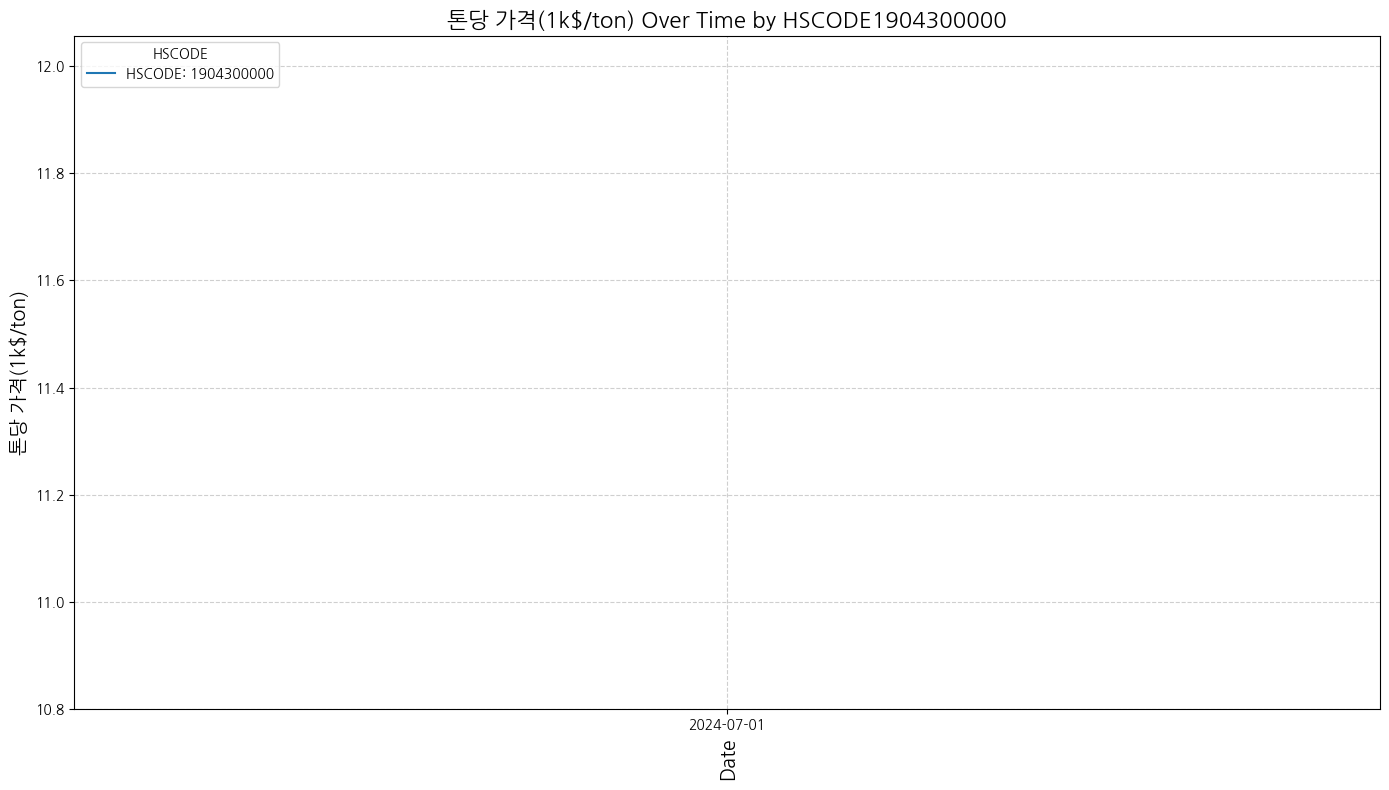

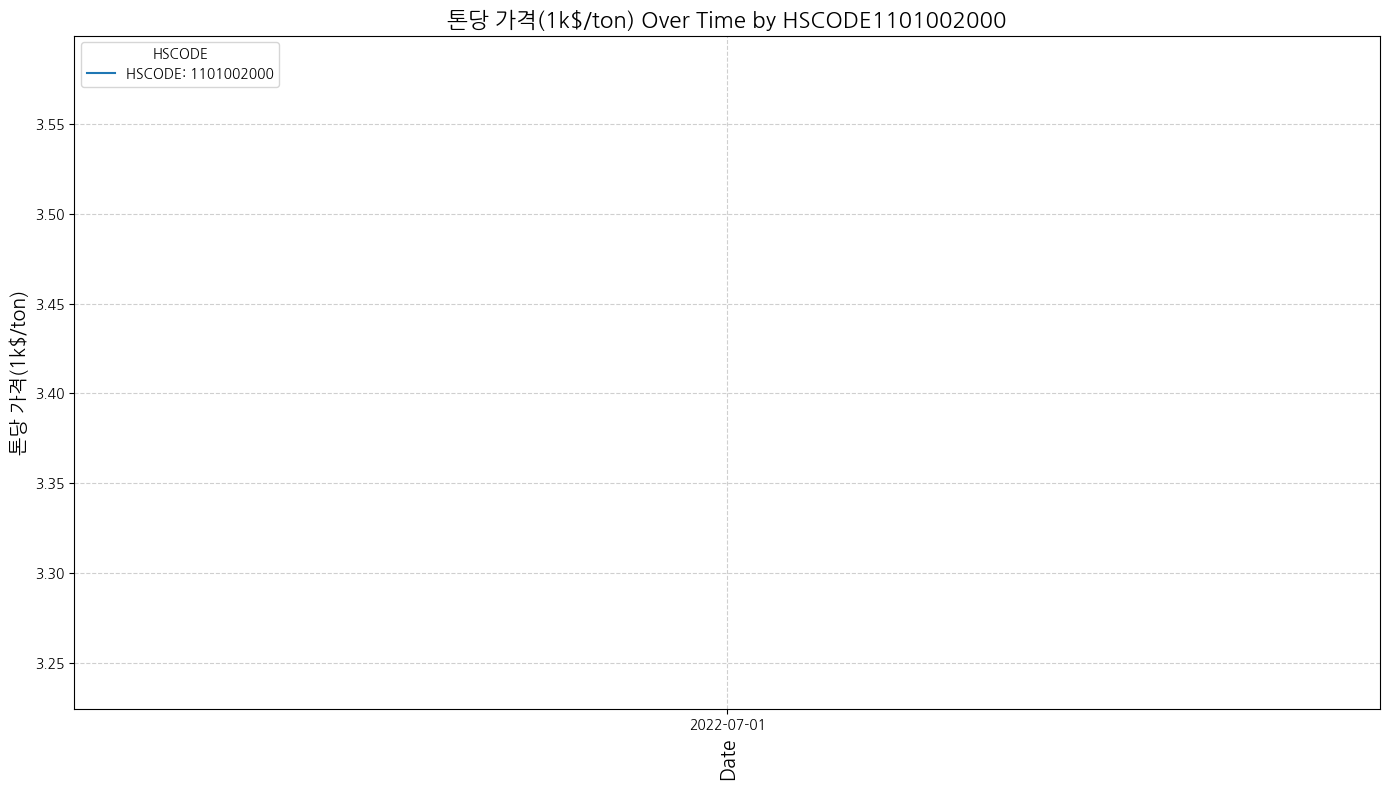

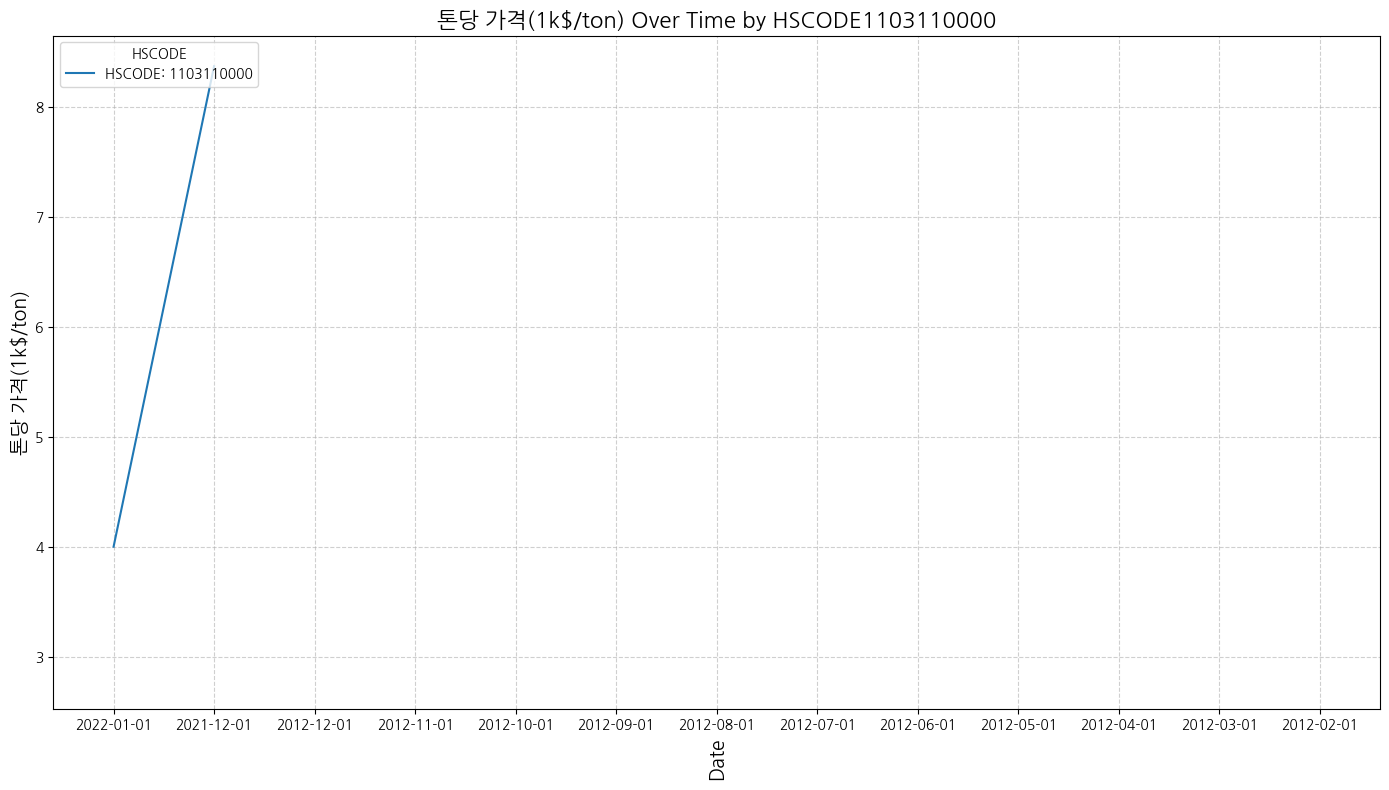

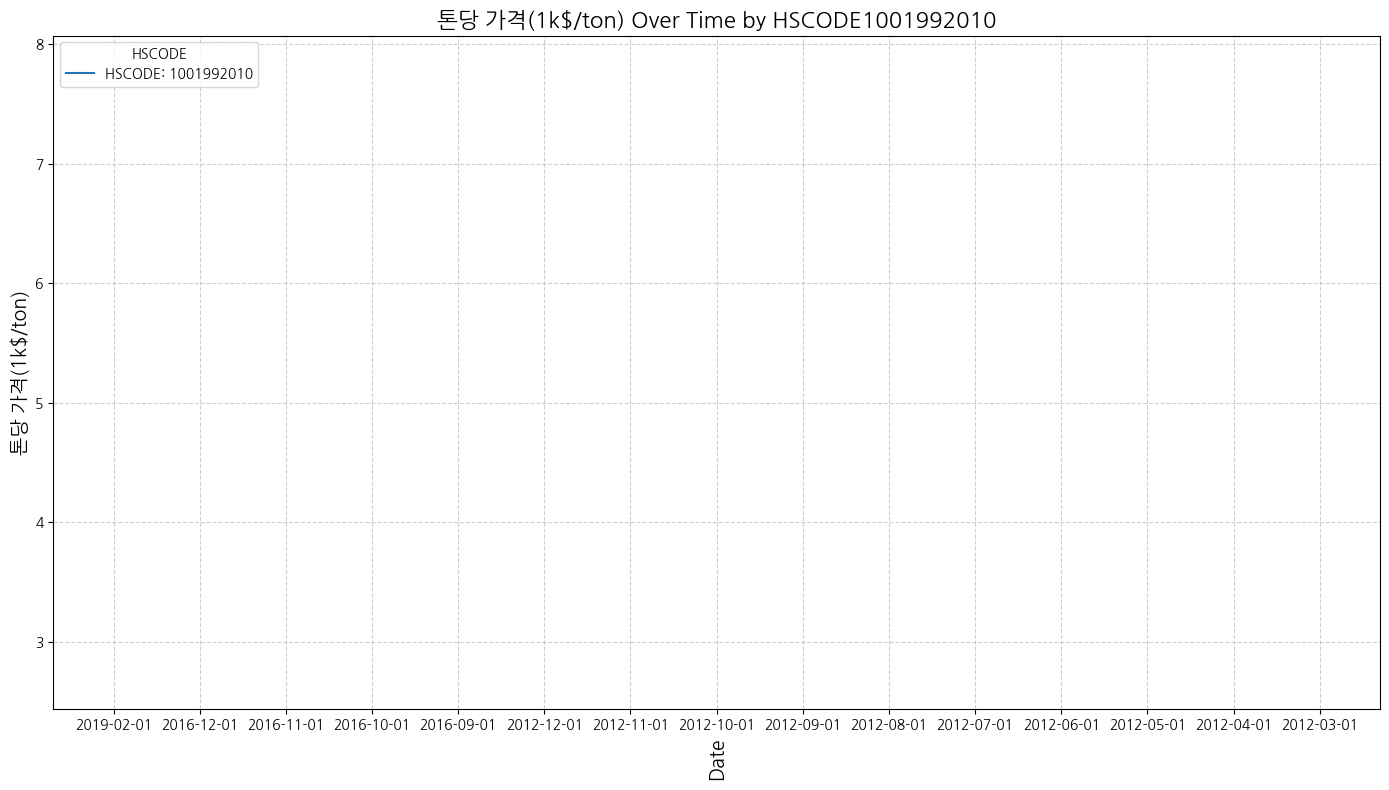

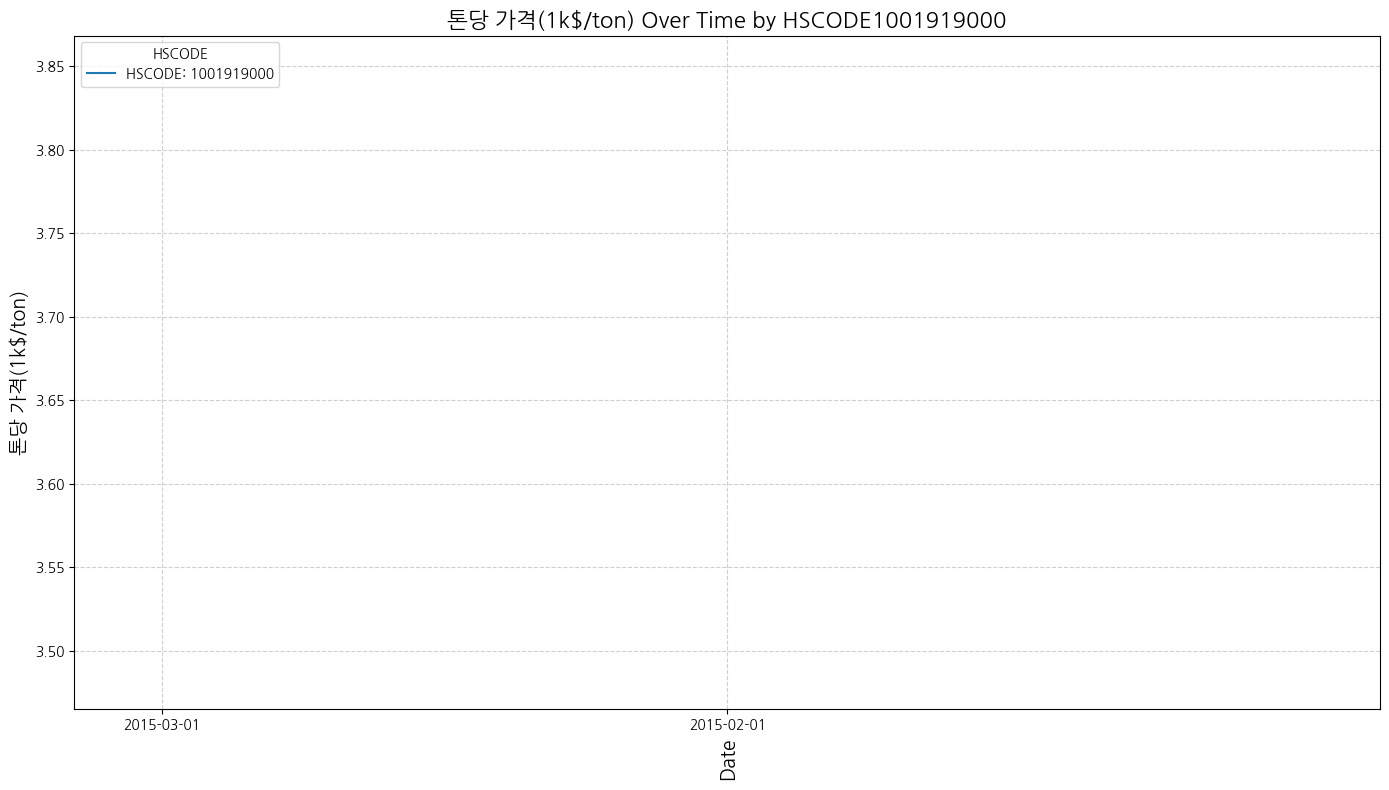

In [45]:
# Plot 톤당 가격 over time by HSCODE
# => 1001992090만 모든 시계열에 대해 존재
# => 해당 hscode를 갖는 밀 톤당 가격 데이터를 사용.

for hscode in unique_hscodes:
    group_data = price[price['HSCODE'] == hscode]
    plt.figure(figsize=(14, 8))

    # Group data by HSCODE and plot each group
    # for hscode, group_data in price.groupby("HSCODE"):
    #     plt.plot(group_data["DATE"], group_data["톤당 가격(1k$/ton)"], label=f"HSCODE: {hscode}")
    # group_data = price[price['HSCODE']==1101001000]
    plot = plt.plot(group_data["DATE"], group_data["톤당 가격(1k$/ton)"], label=f"HSCODE: {hscode}")
    # Customize plot
    plt.title(f"톤당 가격(1k$/ton) Over Time by HSCODE{hscode}", fontsize=16)
    plt.xlabel("Date", fontsize=14, rotation = 90)
    plt.ylabel("톤당 가격(1k$/ton)", rotation = 90, fontsize=14)
    plt.legend(title="HSCODE", fontsize=10, loc="upper left")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()

# Show the plot
plt.show()

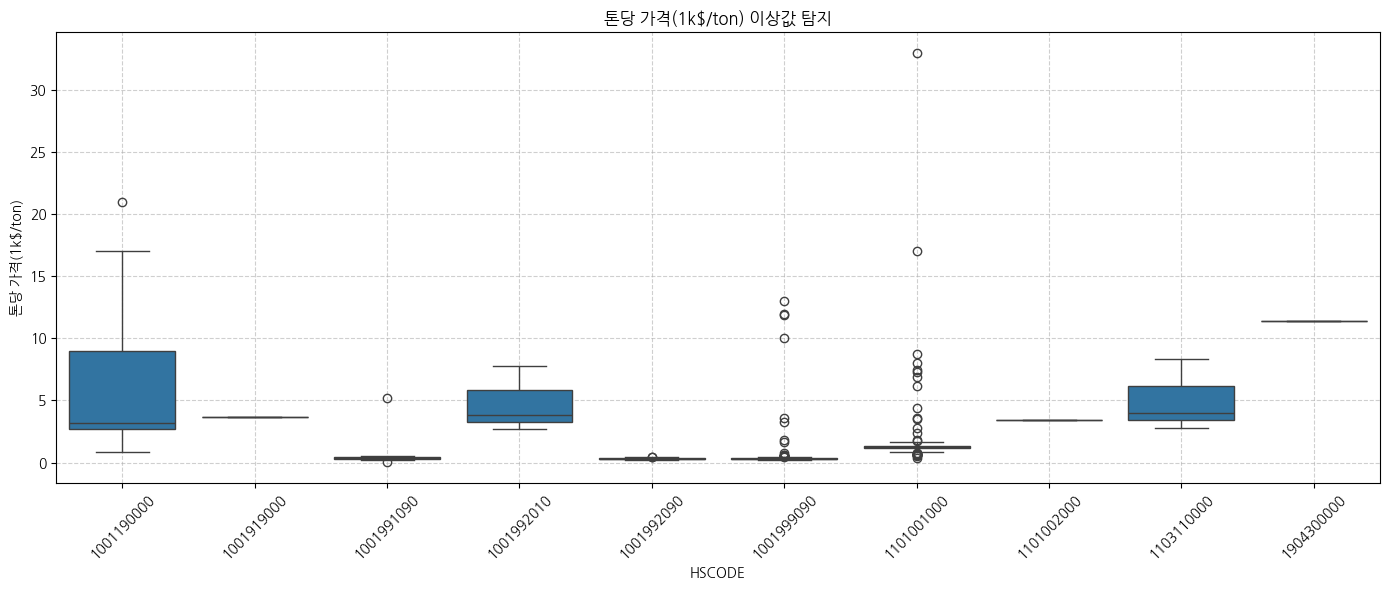

In [46]:

# 2. 이상값 확인 (박스플롯)
plt.figure(figsize=(14, 6))
sns.boxplot(data=price, x="HSCODE", y="톤당 가격(1k$/ton)")
plt.title("톤당 가격(1k$/ton) 이상값 탐지")
plt.xlabel("HSCODE")
plt.ylabel("톤당 가격(1k$/ton)")
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

In [47]:
price_1001992090 = price[price['HSCODE']==1001992090]
price_1001992090.reset_index(drop=True, inplace=True)
price_1001992090 = price_1001992090.groupby("DATE", as_index=False).sum()
display(price_1001992090.head())
display(price_1001992090.tail())

,DATE,구분,품목명,국가명,HSCODE,금액 (1k$),중량 (ton),톤당 가격(1k$/ton)
0,2012-01-01,수입,밀,오스트레일리아,1001992090,28020787.0,88376145.0,0.317063
1,2012-02-01,수입,밀,오스트레일리아,1001992090,27372025.0,87069571.0,0.314370
2,2012-03-01,수입,밀,오스트레일리아,1001992090,25521927.0,82160625.0,0.310635
3,2012-04-01,수입,밀,오스트레일리아,1001992090,17480303.0,60601427.0,0.288447
4,2012-05-01,수입,밀,오스트레일리아,1001992090,25290935.0,80683600.0,0.313458


,DATE,구분,품목명,국가명,HSCODE,금액 (1k$),중량 (ton),톤당 가격(1k$/ton)
149,2024-06-01,수입,밀,오스트레일리아,1001992090,46154457.0,139811400.0,0.330119
150,2024-07-01,수입,밀,오스트레일리아,1001992090,42986172.0,135847050.0,0.316431
151,2024-08-01,수입,밀,오스트레일리아,1001992090,29289942.0,94493690.0,0.309967
152,2024-09-01,수입,밀,오스트레일리아,1001992090,37626691.0,115470140.0,0.325856
153,2024-10-01,수입,밀,오스트레일리아,1001992090,29186447.0,84970080.0,0.343491


In [48]:
print(climate_data['WA'].tail())

                   지점명 시각 (YYYY-MM-DD)  월평균 일 최고기온 (°C)  월평균 일 최저기온 (°C)  \
163  Geraldton Airport      2024-08-01             20.8             11.1   
164  Geraldton Airport      2024-09-01             24.6              9.8   
165  Geraldton Airport      2024-10-01             26.0             12.6   
166  Geraldton Airport      2024-11-01              NaN              NaN   
167  Geraldton Airport      2024-12-01              NaN              NaN   

     월별 일 최고기온(°C)  월별 일 최저기온(°C)  월 총 강수량 (mm)  월평균 일 태양복사량 (MJ/m^2)  Year  
163           25.7            6.0          81.6                  15.1  2024  
164           30.9            6.2          16.4                  20.2  2024  
165           35.8            6.9          36.4                  22.4  2024  
166            NaN            NaN           NaN                  25.9  2024  
167            NaN            NaN           NaN                   NaN  2024  


In [49]:
# Combine state-wise climate data into one dataframe for Australia
import pandas as pd

# List of state-wise climate dataframes
state_climate_data = ["WA", "SA", "VIC", "NSW"]

# Concatenate all state climate dataframes into a single dataframe
australia_climate_data = pd.concat([climate_data[state] for state in state_climate_data])

# Drop '지점명' and 'Year' columns
australia_climate_data = australia_climate_data.drop(columns=["지점명", "Year"])

# Group by '시각 (YYYY-MM-DD)' and calculate the mean for each group
# 각 주별 기후데이터를 평균을 내서함
mean_climate_data = australia_climate_data.groupby("시각 (YYYY-MM-DD)", as_index=False).mean()




In [50]:
# Display the new dataframe
print(mean_climate_data.head())

mean_climate_data.info()

  시각 (YYYY-MM-DD)  월평균 일 최고기온 (°C)  월평균 일 최저기온 (°C)  월별 일 최고기온(°C)  \
0      2011-01-01        31.933333        17.500000      43.100000   
1      2011-02-01        30.800000        18.033333      38.900000   
2      2011-03-01        26.433333        15.133333      36.433333   
3      2011-04-01        24.666667        11.433333      31.333333   
4      2011-05-01        19.166667         8.100000      25.833333   

   월별 일 최저기온(°C)  월 총 강수량 (mm)  월평균 일 태양복사량 (MJ/m^2)  
0      11.966667     14.400000                26.600  
1      12.500000     78.000000                22.725  
2       9.033333     52.200000                18.700  
3       6.400000     27.666667                16.375  
4       1.800000     35.933333                11.325  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   시각 (YYYY-MM-DD)       168 non-null    

In [51]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr

# Merge price and climate data
# price["DATE"] = pd.to_datetime(price["DATE"], format="%Y%m").dt.strftime("%Y-%m-01")
merged_data = pd.merge(price_1001992090, mean_climate_data, left_on="DATE", right_on="시각 (YYYY-MM-DD)")
merged_data = merged_data.drop(columns=["구분", "품목명", "국가명", "시각 (YYYY-MM-DD)", 'HSCODE'])


In [52]:
display(merged_data.head())
display(merged_data.tail())
merged_data.info()

,DATE,금액 (1k$),중량 (ton),톤당 가격(1k$/ton),월평균 일 최고기온 (°C),월평균 일 최저기온 (°C),월별 일 최고기온(°C),월별 일 최저기온(°C),월 총 강수량 (mm),월평균 일 태양복사량 (MJ/m^2)
0,2012-01-01,28020787.0,88376145.0,0.317063,31.750,18.525,41.125,11.600,39.05,26.300
1,2012-02-01,27372025.0,87069571.0,0.314370,29.450,17.150,38.550,11.875,68.10,22.550
2,2012-03-01,25521927.0,82160625.0,0.310635,29.325,15.325,37.225,10.350,19.55,21.200
3,2012-04-01,17480303.0,60601427.0,0.288447,26.500,12.925,35.350,6.575,14.15,16.025
4,2012-05-01,25290935.0,80683600.0,0.313458,21.575,8.575,30.225,3.725,39.10,11.975


,DATE,금액 (1k$),중량 (ton),톤당 가격(1k$/ton),월평균 일 최고기온 (°C),월평균 일 최저기온 (°C),월별 일 최고기온(°C),월별 일 최저기온(°C),월 총 강수량 (mm),월평균 일 태양복사량 (MJ/m^2)
149,2024-06-01,46154457.0,139811400.0,0.330119,17.850,7.700,24.100,2.475,70.025,10.175
150,2024-07-01,42986172.0,135847050.0,0.316431,17.150,6.875,22.125,1.000,69.150,11.725
151,2024-08-01,29289942.0,94493690.0,0.309967,21.125,9.125,28.300,3.075,38.350,14.300
152,2024-09-01,37626691.0,115470140.0,0.325856,22.975,8.250,30.650,2.350,15.850,18.425
153,2024-10-01,29186447.0,84970080.0,0.343491,27.300,11.525,34.700,5.450,24.725,21.950


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154 entries, 0 to 153
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   DATE                  154 non-null    object 
 1   금액 (1k$)              154 non-null    float64
 2   중량 (ton)              154 non-null    float64
 3   톤당 가격(1k$/ton)        154 non-null    float64
 4   월평균 일 최고기온 (°C)       154 non-null    float64
 5   월평균 일 최저기온 (°C)       154 non-null    float64
 6   월별 일 최고기온(°C)         154 non-null    float64
 7   월별 일 최저기온(°C)         154 non-null    float64
 8   월 총 강수량 (mm)          154 non-null    float64
 9   월평균 일 태양복사량 (MJ/m^2)  154 non-null    float64
dtypes: float64(9), object(1)
memory usage: 12.2+ KB


/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


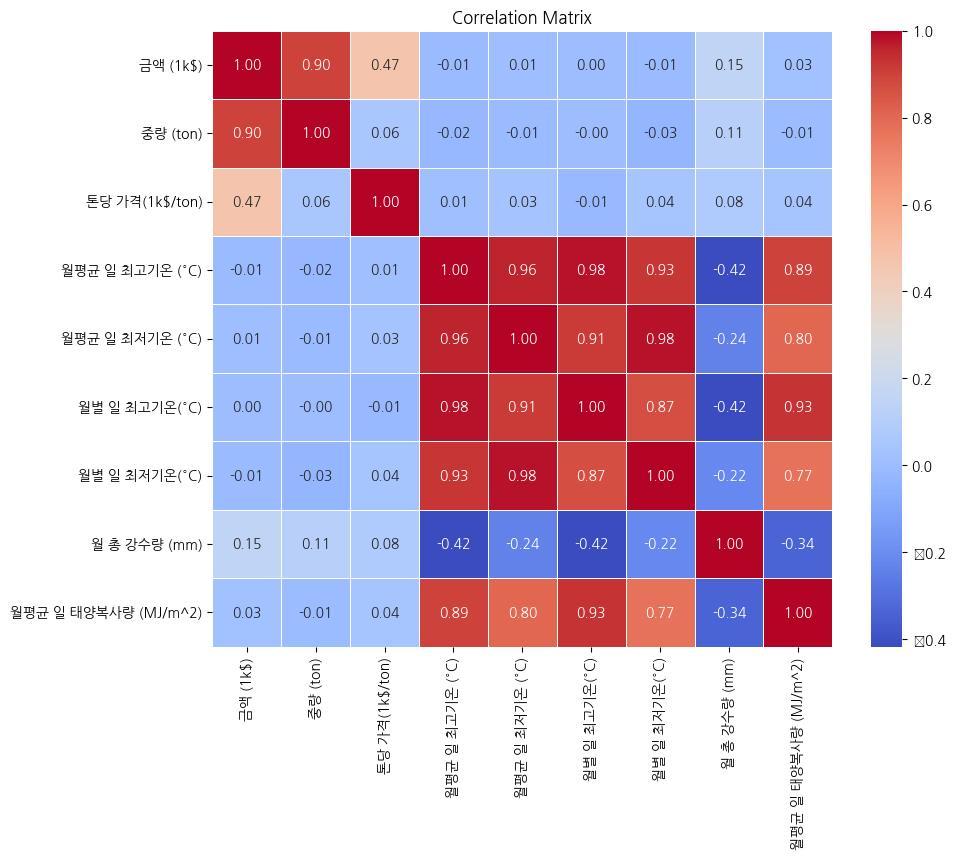

In [53]:
#  Remove non-numeric columns for correlation matrix
numeric_columns = merged_data.select_dtypes(include=["number"])
correlation_matrix = numeric_columns.corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()


Regression Coefficients: [-0.0008135   0.00024431  0.00130835]
Intercept: 0.3038303786302445
R2 Score: 0.01254721034604267
Mean Squared Error: 0.002685727575261883


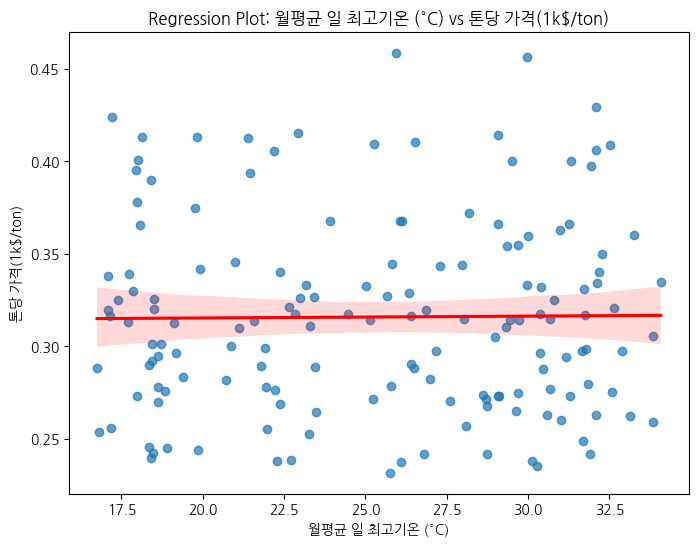

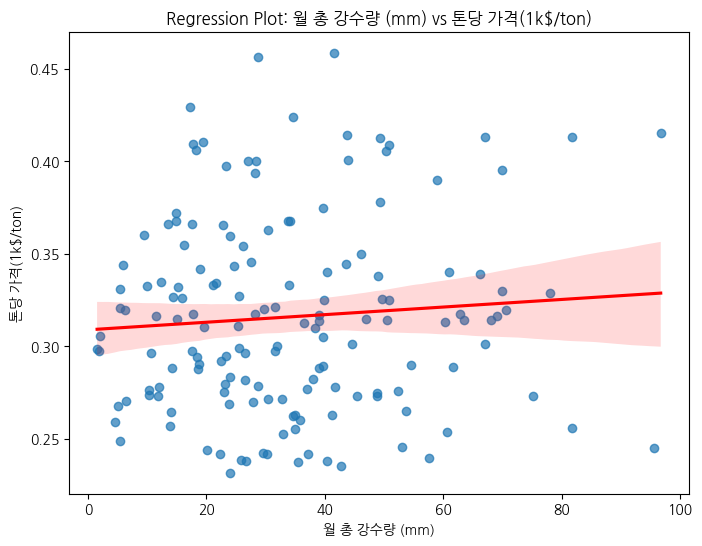

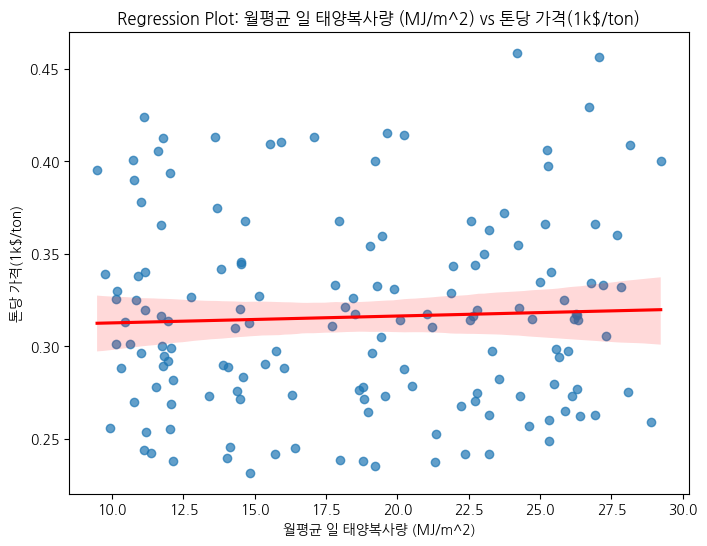

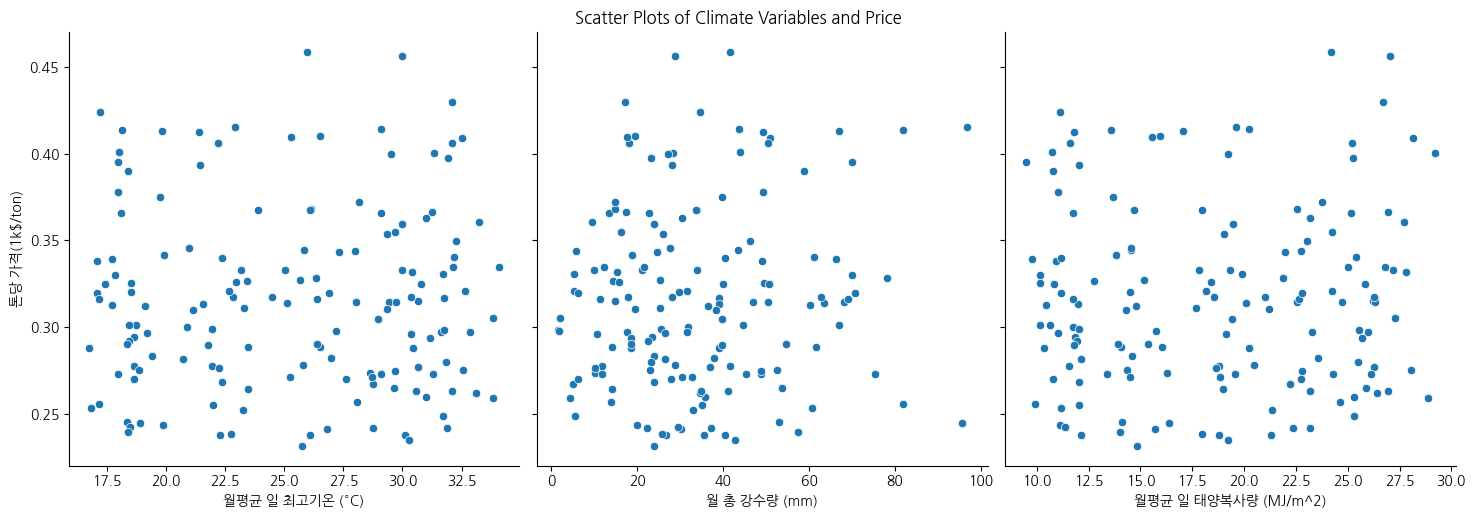

In [54]:
# Regression analysis
X = merged_data[["월평균 일 최고기온 (°C)", "월 총 강수량 (mm)", "월평균 일 태양복사량 (MJ/m^2)"]]
y = merged_data["톤당 가격(1k$/ton)"]

# Fit regression model
model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

# Regression results
print("Regression Coefficients:", model.coef_)
print("Intercept:", model.intercept_)
print("R2 Score:", r2_score(y, y_pred))
print("Mean Squared Error:", mean_squared_error(y, y_pred))

# Regression plots
for feature in X.columns:
    plt.figure(figsize=(8, 6))
    sns.regplot(x=merged_data[feature], y=merged_data["톤당 가격(1k$/ton)"], line_kws={"color": "red"}, scatter_kws={"alpha": 0.7})
    plt.title(f"Regression Plot: {feature} vs 톤당 가격(1k$/ton)")
    plt.xlabel(feature)
    plt.ylabel("톤당 가격(1k$/ton)")
    plt.show()

# Scatter plots
sns.pairplot(merged_data, x_vars=X.columns, y_vars=["톤당 가격(1k$/ton)"], height=5, aspect=1, diag_kind="kde", kind="scatter")
plt.suptitle("Scatter Plots of Climate Variables and Price", y=1.02)
plt.show()

In [55]:
merged_data.head()

,DATE,금액 (1k$),중량 (ton),톤당 가격(1k$/ton),월평균 일 최고기온 (°C),월평균 일 최저기온 (°C),월별 일 최고기온(°C),월별 일 최저기온(°C),월 총 강수량 (mm),월평균 일 태양복사량 (MJ/m^2)
0,2012-01-01,28020787.0,88376145.0,0.317063,31.750,18.525,41.125,11.600,39.05,26.300
1,2012-02-01,27372025.0,87069571.0,0.314370,29.450,17.150,38.550,11.875,68.10,22.550
2,2012-03-01,25521927.0,82160625.0,0.310635,29.325,15.325,37.225,10.350,19.55,21.200
3,2012-04-01,17480303.0,60601427.0,0.288447,26.500,12.925,35.350,6.575,14.15,16.025
4,2012-05-01,25290935.0,80683600.0,0.313458,21.575,8.575,30.225,3.725,39.10,11.975


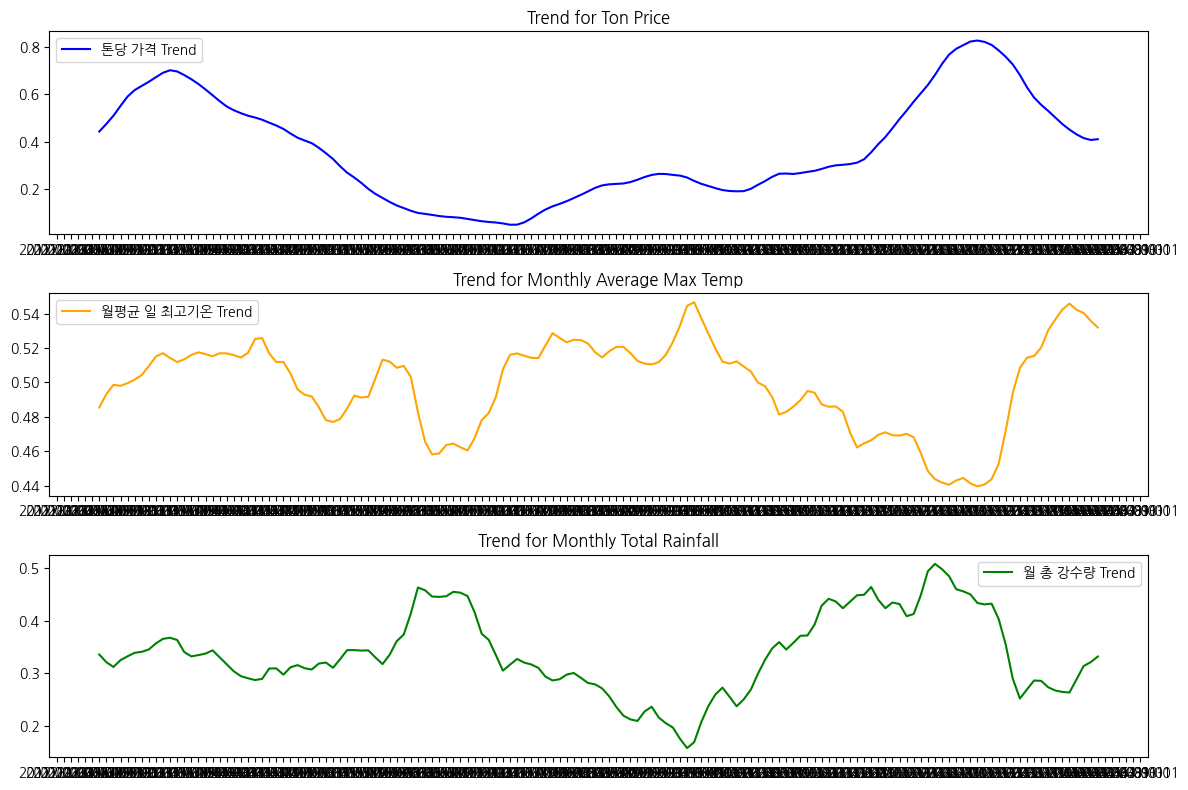

In [56]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
merged_data[['톤당 가격(1k$/ton)', '월평균 일 최고기온 (°C)', '월 총 강수량 (mm)']] = scaler.fit_transform(
    merged_data[['톤당 가격(1k$/ton)', '월평균 일 최고기온 (°C)', '월 총 강수량 (mm)']]
)

# Decompose and extract trend
merged_data.set_index('DATE', inplace=True)
decomposed_price = seasonal_decompose(merged_data['톤당 가격(1k$/ton)'], model='additive', period=12)
decomposed_temp = seasonal_decompose(merged_data['월평균 일 최고기온 (°C)'], model='additive', period=12)
decomposed_rain = seasonal_decompose(merged_data['월 총 강수량 (mm)'], model='additive', period=12)

# Plot trends
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(decomposed_price.trend, label='톤당 가격 Trend', color='blue')
plt.title('Trend for Ton Price')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(decomposed_temp.trend, label='월평균 일 최고기온 Trend', color='orange')
plt.title('Trend for Monthly Average Max Temp')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(decomposed_rain.trend, label='월 총 강수량 Trend', color='green')
plt.title('Trend for Monthly Total Rainfall')
plt.legend()

plt.tight_layout()
plt.show()

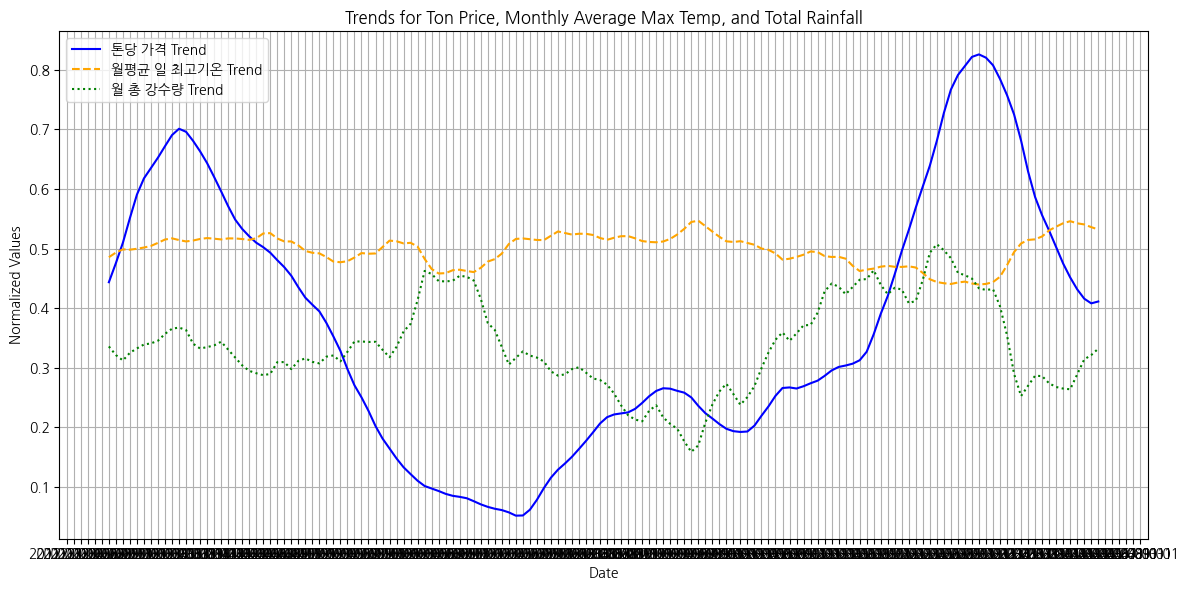

In [57]:
# Plot all trends on the same figure
plt.figure(figsize=(12, 6))

plt.plot(decomposed_price.trend, label='톤당 가격 Trend', color='blue', linestyle='-')
plt.plot(decomposed_temp.trend, label='월평균 일 최고기온 Trend', color='orange', linestyle='--')
plt.plot(decomposed_rain.trend, label='월 총 강수량 Trend', color='green', linestyle=':')

plt.title('Trends for Ton Price, Monthly Average Max Temp, and Total Rainfall')
plt.xlabel('Date')
plt.ylabel('Normalized Values')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/seasonal.py:360: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


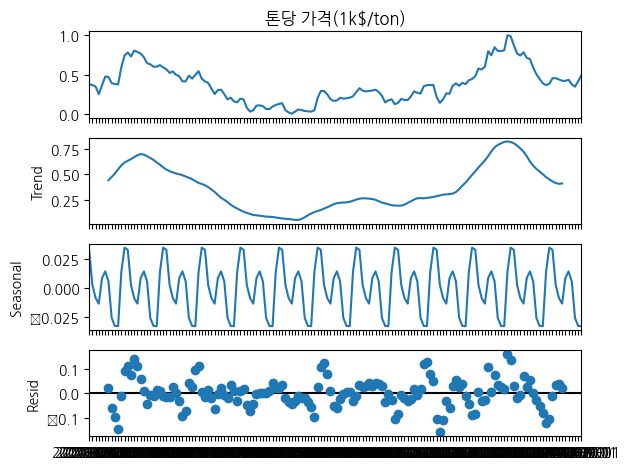

In [58]:
# Perform seasonal decomposition of 금액 (1k$)
decomposition = seasonal_decompose(merged_data["톤당 가격(1k$/ton)"], model="additive", period=12)
decomposition.plot()
plt.show()


In [59]:
import statsmodels.api as sm

# Prepare data for regression analysis
x = merged_data[x_labels]
y = merged_data["톤당 가격(1k$/ton)"]

# Add constant to the independent variables
x = sm.add_constant(x)

# Perform regression analysis
model = sm.OLS(y, x).fit()

# Regression summary
summary = model.summary()

# Display regression summary
print(summary)

# Analyze the results
coefficients = model.params
p_values = model.pvalues
r_squared = model.rsquared

analysis = {
    "coefficients": coefficients.to_dict(),
    "p_values": p_values.to_dict(),
    "r_squared": r_squared
}

analysis


                            OLS Regression Results                            
Dep. Variable:         톤당 가격(1k$/ton)   R-squared:                       0.052
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     1.331
Date:                Sat, 07 Dec 2024   Prob (F-statistic):              0.247
Time:                        04:04:50   Log-Likelihood:                 12.069
No. Observations:                 154   AIC:                            -10.14
Df Residuals:                     147   BIC:                             11.12
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.8058 

{'coefficients': {'const': 0.8058431047866865,
  '월평균 일 최고기온 (°C)': 0.19962966815774558,
  '월평균 일 최저기온 (°C)': 0.024210886638296195,
  '월별 일 최고기온(°C)': -0.036051570716813655,
  '월별 일 최저기온(°C)': -0.005531696556490755,
  '월 총 강수량 (mm)': -0.001146146729199559,
  '월평균 일 태양복사량 (MJ/m^2)': 0.022507841018183282},
 'p_values': {'const': 0.0331911668137879,
  '월평균 일 최고기온 (°C)': 0.7375487895613504,
  '월평균 일 최저기온 (°C)': 0.5070981204111462,
  '월별 일 최고기온(°C)': 0.033196967666723476,
  '월별 일 최저기온(°C)': 0.8218898223070847,
  '월 총 강수량 (mm)': 0.9936066513040384,
  '월평균 일 태양복사량 (MJ/m^2)': 0.031252880040341234},
 'r_squared': 0.051518828437572606}

회귀 계수 (Coefficients): [-0.06208291  0.10244982  0.11382384]
절편 (Intercept): 0.3142648559737707
R2 Score: 0.012547210346042448
Mean Squared Error: 0.052112754018123285


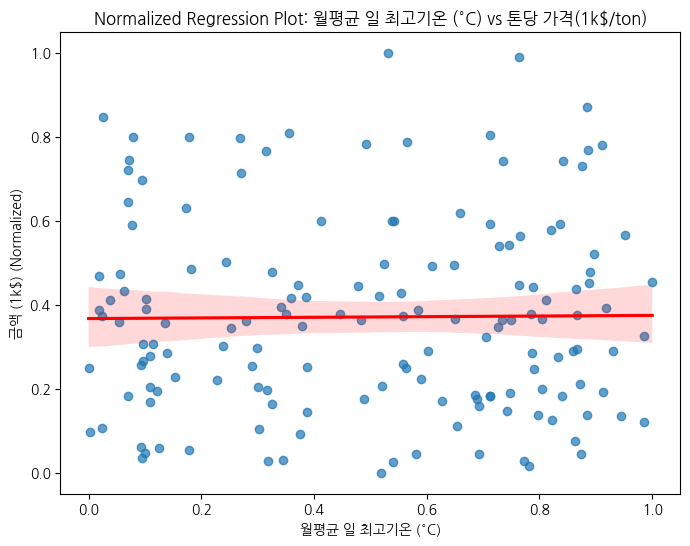

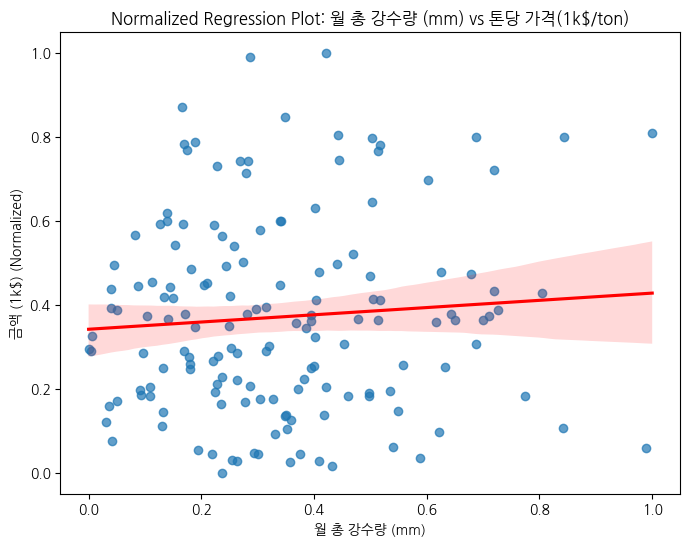

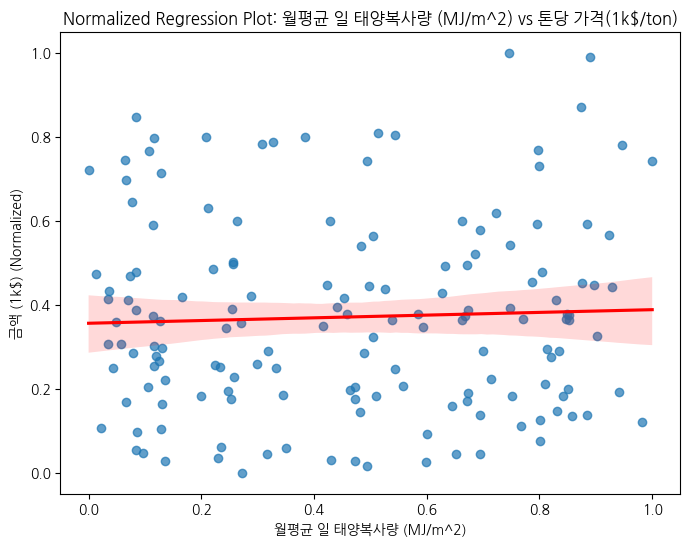

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터 정규화
scaler = MinMaxScaler()
normalized_data = merged_data.copy()
normalized_columns = ["톤당 가격(1k$/ton)", "월평균 일 최고기온 (°C)", "월 총 강수량 (mm)", "월평균 일 태양복사량 (MJ/m^2)"]
normalized_data[normalized_columns] = scaler.fit_transform(normalized_data[normalized_columns])

# 독립변수와 종속변수 설정
X = normalized_data[["월평균 일 최고기온 (°C)", "월 총 강수량 (mm)", "월평균 일 태양복사량 (MJ/m^2)"]]
y = normalized_data["톤당 가격(1k$/ton)"]

# 회귀 모델 학습
model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

# 회귀 분석 결과 출력
print("회귀 계수 (Coefficients):", model.coef_)
print("절편 (Intercept):", model.intercept_)
print("R2 Score:", r2_score(y, y_pred))
print("Mean Squared Error:", mean_squared_error(y, y_pred))

# 각 독립변수에 대한 회귀 플롯
for feature in X.columns:
    plt.figure(figsize=(8, 6))
    sns.regplot(x=normalized_data[feature], y=normalized_data["톤당 가격(1k$/ton)"], line_kws={"color": "red"}, scatter_kws={"alpha": 0.7})
    plt.title(f"Normalized Regression Plot: {feature} vs 톤당 가격(1k$/ton)")
    plt.xlabel(feature)
    plt.ylabel("금액 (1k$) (Normalized)")
    plt.show()
